In [3]:
import sys
import os
import gc
import copy
import yaml
import random
import shutil
import time
import typing as tp
from glob import glob
from pathlib import Path
from collections import OrderedDict, defaultdict
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from scipy.signal import butter, lfilter, freqz, filtfilt,iirnotch 

import torch
from torch import nn
from torch import optim
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.cuda import amp
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, default_collate
import torchvision.models as models
import torch.nn.functional as F
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split

import timm
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

import albumentations as A
from albumentations.pytorch import ToTensorV2

from captum.attr import Saliency, IntegratedGradients

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [4]:
!pwd

/home/data2/ronak/kou


In [5]:
class CFG:
    debug = True
    AUGMENT = True
    VALIDATION_FRAC = 0.4
    AUGMENTATION_FRACTION = 0.05
    EPOCHS = 100
    
    
    
    
    
    #checkpoint_dir = "/Users/koushani/Documents/UB-COURSEWORK/SPRING24/XAI_HMS_KAGGLE/CODING/checkpoints"
    checkpoint_dir = "/home/data2/ronak/kou/checkpoints"
    last_optimizer = None
    last_regularization_lambda = None
    checkpointing_enabled = True
    
    
    EEG = True
    SPEC = True

    SKIP_ASSERT = False
    
    
    seed = 42
    gpu_idx = 0

    device = torch.device('cuda')
    
    EEG_COLUMNS =  [ # to assert columns order is the same
    'Fp1','F3', 'C3', 'P3', 'F7', 
    'T3', 'T5', 'O1', 'Fz', 'Cz', 
    'Pz', 'Fp2', 'F4', 'C4', 'P4',
    'F8', 'T4', 'T6', 'O2', 'EKG'
    ]
    
    eeg_features = [column for column in EEG_COLUMNS if column != 'EKG'] # [ 'EKG' ]
    
    classes = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']
    label2name = dict(enumerate(classes))
    name2label = {v: k for k, v in label2name.items()}
    n_classes = len(classes)
    
    # Spectrogram columns
    SPECTR_COLUMNS = [
    'time', 'LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 
    'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34', 'LL_2.54', 
    'LL_2.73', 'LL_2.93', 'LL_3.13', 'LL_3.32', 'LL_3.52', 'LL_3.71', 
    'LL_3.91', 'LL_4.1', 'LL_4.3', 'LL_4.49', 'LL_4.69', 'LL_4.88', 
    'LL_5.08', 'LL_5.27', 'LL_5.47', 'LL_5.66', 'LL_5.86', 'LL_6.05', 
    'LL_6.25', 'LL_6.45', 'LL_6.64', 'LL_6.84', 'LL_7.03', 'LL_7.23', 
    'LL_7.42', 'LL_7.62', 'LL_7.81', 'LL_8.01', 'LL_8.2', 'LL_8.4', 
    'LL_8.59', 'LL_8.79', 'LL_8.98', 'LL_9.18', 'LL_9.38', 'LL_9.57', 
    'LL_9.77', 'LL_9.96', 'LL_10.16', 'LL_10.35', 'LL_10.55', 'LL_10.74', 
    'LL_10.94', 'LL_11.13', 'LL_11.33', 'LL_11.52', 'LL_11.72', 'LL_11.91', 
    'LL_12.11', 'LL_12.3', 'LL_12.5', 'LL_12.7', 'LL_12.89', 'LL_13.09', 
    'LL_13.28', 'LL_13.48', 'LL_13.67', 'LL_13.87', 'LL_14.06', 'LL_14.26', 
    'LL_14.45', 'LL_14.65', 'LL_14.84', 'LL_15.04', 'LL_15.23', 'LL_15.43', 
    'LL_15.63', 'LL_15.82', 'LL_16.02', 'LL_16.21', 'LL_16.41', 'LL_16.6', 
    'LL_16.8', 'LL_16.99', 'LL_17.19', 'LL_17.38', 'LL_17.58', 'LL_17.77', 
    'LL_17.97', 'LL_18.16', 'LL_18.36', 'LL_18.55', 'LL_18.75', 'LL_18.95', 
    'LL_19.14', 'LL_19.34', 'LL_19.53', 'LL_19.73', 'LL_19.92', 'RL_0.59', 
    'RL_0.78', 'RL_0.98', 'RL_1.17', 'RL_1.37', 'RL_1.56', 'RL_1.76', 
    'RL_1.95', 'RL_2.15', 'RL_2.34', 'RL_2.54', 'RL_2.73', 'RL_2.93', 
    'RL_3.13', 'RL_3.32', 'RL_3.52', 'RL_3.71', 'RL_3.91', 'RL_4.1', 
    'RL_4.3', 'RL_4.49', 'RL_4.69', 'RL_4.88', 'RL_5.08', 'RL_5.27', 
    'RL_5.47', 'RL_5.66', 'RL_5.86', 'RL_6.05', 'RL_6.25', 'RL_6.45', 
    'RL_6.64', 'RL_6.84', 'RL_7.03', 'RL_7.23', 'RL_7.42', 'RL_7.62', 
    'RL_7.81', 'RL_8.01', 'RL_8.2', 'RL_8.4', 'RL_8.59', 'RL_8.79', 
    'RL_8.98', 'RL_9.18', 'RL_9.38', 'RL_9.57', 'RL_9.77', 'RL_9.96', 
    'RL_10.16', 'RL_10.35', 'RL_10.55', 'RL_10.74', 'RL_10.94', 'RL_11.13', 
    'RL_11.33', 'RL_11.52', 'RL_11.72', 'RL_11.91', 'RL_12.11', 'RL_12.3', 
    'RL_12.5', 'RL_12.7', 'RL_12.89', 'RL_13.09', 'RL_13.28', 'RL_13.48', 
    'RL_13.67', 'RL_13.87', 'RL_14.06', 'RL_14.26', 'RL_14.45', 'RL_14.65', 
    'RL_14.84', 'RL_15.04', 'RL_15.23', 'RL_15.43', 'RL_15.63', 'RL_15.82', 
    'RL_16.02', 'RL_16.21', 'RL_16.41', 'RL_16.6', 'RL_16.8', 'RL_16.99', 
    'RL_17.19', 'RL_17.38', 'RL_17.58', 'RL_17.77', 'RL_17.97', 'RL_18.16', 
    'RL_18.36', 'RL_18.55', 'RL_18.75', 'RL_18.95', 'RL_19.14', 'RL_19.34', 
    'RL_19.53', 'RL_19.73', 'RL_19.92', 'LP_0.59', 'LP_0.78', 'LP_0.98', 
    'LP_1.17', 'LP_1.37', 'LP_1.56', 'LP_1.76', 'LP_1.95', 'LP_2.15', 
    'LP_2.34', 'LP_2.54', 'LP_2.73', 'LP_2.93', 'LP_3.13', 'LP_3.32', 
    'LP_3.52', 'LP_3.71', 'LP_3.91', 'LP_4.1', 'LP_4.3', 'LP_4.49', 
    'LP_4.69', 'LP_4.88', 'LP_5.08', 'LP_5.27', 'LP_5.47', 'LP_5.66', 
    'LP_5.86', 'LP_6.05', 'LP_6.25', 'LP_6.45', 'LP_6.64', 'LP_6.84', 
    'LP_7.03', 'LP_7.23', 'LP_7.42', 'LP_7.62', 'LP_7.81', 'LP_8.01', 
    'LP_8.2', 'LP_8.4', 'LP_8.59', 'LP_8.79', 'LP_8.98', 'LP_9.18', 
    'LP_9.38', 'LP_9.57', 'LP_9.77', 'LP_9.96', 'LP_10.16', 'LP_10.35', 
    'LP_10.55', 'LP_10.74', 'LP_10.94', 'LP_11.13', 'LP_11.33', 'LP_11.52', 
    'LP_11.72', 'LP_11.91', 'LP_12.11', 'LP_12.3', 'LP_12.5', 'LP_12.7', 
    'LP_12.89', 'LP_13.09', 'LP_13.28', 'LP_13.48', 'LP_13.67', 'LP_13.87', 
    'LP_14.06', 'LP_14.26', 'LP_14.45', 'LP_14.65', 'LP_14.84', 'LP_15.04', 
    'LP_15.23', 'LP_15.43', 'LP_15.63', 'LP_15.82', 'LP_16.02', 'LP_16.21', 
    'LP_16.41', 'LP_16.6', 'LP_16.8', 'LP_16.99', 'LP_17.19', 'LP_17.38', 
    'LP_17.58', 'LP_17.77', 'LP_17.97', 'LP_18.16', 'LP_18.36', 'LP_18.55', 
    'LP_18.75', 'LP_18.95', 'LP_19.14', 'LP_19.34', 'LP_19.53', 'LP_19.73', 
    'LP_19.92', 'RP_0.59', 'RP_0.78', 'RP_0.98', 'RP_1.17', 'RP_1.37', 
    'RP_1.56', 'RP_1.76', 'RP_1.95', 'RP_2.15', 'RP_2.34', 'RP_2.54', 
    'RP_2.73', 'RP_2.93', 'RP_3.13', 'RP_3.32', 'RP_3.52', 'RP_3.71', 
    'RP_3.91', 'RP_4.1', 'RP_4.3', 'RP_4.49', 'RP_4.69', 'RP_4.88', 
    'RP_5.08', 'RP_5.27', 'RP_5.47', 'RP_5.66', 'RP_5.86', 'RP_6.05', 
    'RP_6.25', 'RP_6.45', 'RP_6.64', 'RP_6.84', 'RP_7.03', 'RP_7.23', 
    'RP_7.42', 'RP_7.62', 'RP_7.81', 'RP_8.01', 'RP_8.2', 'RP_8.4', 
    'RP_8.59', 'RP_8.79', 'RP_8.98', 'RP_9.18', 'RP_9.38', 'RP_9.57', 
    'RP_9.77', 'RP_9.96', 'RP_10.16', 'RP_10.35', 'RP_10.55', 'RP_10.74', 
    'RP_10.94', 'RP_11.13', 'RP_11.33', 'RP_11.52', 'RP_11.72', 'RP_11.91', 
    'RP_12.11', 'RP_12.3', 'RP_12.5', 'RP_12.7', 'RP_12.89', 'RP_13.09', 
    'RP_13.28', 'RP_13.48', 'RP_13.67', 'RP_13.87', 'RP_14.06', 'RP_14.26', 
    'RP_14.45', 'RP_14.65', 'RP_14.84', 'RP_15.04', 'RP_15.23', 'RP_15.43', 
    'RP_15.63', 'RP_15.82', 'RP_16.02', 'RP_16.21', 'RP_16.41', 'RP_16.6', 
    'RP_16.8', 'RP_16.99', 'RP_17.19', 'RP_17.38', 'RP_17.58', 'RP_17.77', 
    'RP_17.97', 'RP_18.16', 'RP_18.36', 'RP_18.55', 'RP_18.75', 'RP_18.95', 
    'RP_19.14', 'RP_19.34', 'RP_19.53', 'RP_19.73', 'RP_19.92'
]


    n_folds = 5
    SPECTROGRAM_COLUMNS = [col for col in SPECTR_COLUMNS if col != 'time']
    
    ## Dataset Preprocessing
    bandpass_filter = {"low": 0.5, "high": 20, "order": 2}
    rand_filter = {"probab": 0.1, "low": 10, "high": 20, "band": 1.0, "order": 2}
    freq_channels = [(0.5, 4.5)]
    filter_order = 2
    random_close_zone = 0.0  # 0.2
    
    map_features = [
        ("Fp1", "F7"), ("F7", "T3"), ("T3", "T5"), ("T5", "O1"),
        ("Fp1", "F3"), ("F3", "C3"), ("C3", "P3"), ("P3", "O1"),
        ("Fp2", "F8"), ("F8", "T4"), ("T4", "T6"), ("T6", "O2"),
        ("Fp2", "F4"), ("F4", "C4"), ("C4", "P4"), ("P4", "O2"),
        ("Fz", "Cz"), ("Cz", "Pz")
    ]
    
    LL = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1']  # Example left EEG channels
    LP = ['Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']  # Example right EEG channels
    RL = LL  # Assuming RL and RP are mirrors of LL and LP respectively
    RP = LP
    
    feature_to_index = {x: y for x, y in zip(eeg_features, range(len(eeg_features)))}
    simple_features = ['Fz', 'Cz', 'Pz', 'EKG']  # 'Fz', 'Cz', 'Pz', 'EKG'
    
    n_map_features = len(map_features)
    in_channels = len(SPECTROGRAM_COLUMNS)
    
    seq_length = 50  # Second's
    sampling_rate = 200  # Hz
    nsamples = seq_length * sampling_rate
    out_samples = nsamples // 5
    
    debug_input_size = 2560
    #input_size = 
    in_chans = 1

    batch_size = 64
    num_workers = 16
    fixed_length = 3000
    image_size = (400, 300)
    
    def seed_everything(self):
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(self.seed)
            torch.cuda.manual_seed_all(self.seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

    def get_device():
        if torch.cuda.is_available():
        # Get the current default CUDA device
            device = torch.device("cuda")
        # Get the name of the device
            device_name = torch.cuda.get_device_name(device)
            print(f"CUDA is available. Using device: {device} ({device_name})")
        else:
            device = torch.device("cpu")
            print("CUDA is not available. Using CPU.")
        return device
    
    
    def stop_checkpointing():
        CFG.checkpointing_enabled = False
        print("Checkpointing disabled.")

    def start_checkpointing():
        CFG.checkpointing_enabled = True
        print("Checkpointing enabled.")
    

In [6]:
def load_checkpoint(checkpoint_dir, checkpoint_filename, model, optimizer):
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint '{checkpoint_path}'")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        valid_losses = checkpoint['valid_losses']
        train_accuracies = checkpoint['train_accuracies']
        valid_accuracies = checkpoint['valid_accuracies']
        lr_scheduler_state = checkpoint.get('lr_scheduler', None)
    else:
        print(f"No checkpoint found at '{checkpoint_path}'")
        start_epoch = 0
        train_losses = []
        valid_losses = []
        train_accuracies = []
        valid_accuracies = []
        lr_scheduler_state = None
    
    return start_epoch, train_losses, valid_losses, train_accuracies, valid_accuracies, lr_scheduler_state





def save_checkpoint(state, checkpoint_dir, checkpoint_filename):
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    torch.save(state, checkpoint_path)
    print(f"Checkpoint saved at '{checkpoint_path}'")
    
    
def detect_and_save_checkpoint(state, checkpoint_dir, optimizer, regularization_lambda):
    # Detect changes in optimizer and regularization parameter
    optimizer_changed = CFG.last_optimizer is None or type(optimizer) != CFG.last_optimizer
    regularization_changed = CFG.last_regularization_lambda is None or regularization_lambda != CFG.last_regularization_lambda
    
    # Initialize the checkpoint filename
    checkpoint_filename = "checkpoint.pth.tar"

    # Modify the checkpoint filename based on the changes detected
    if optimizer_changed and regularization_changed:
        checkpoint_filename = "checkpoint_optimizer_and_regularization.pth.tar"
    elif optimizer_changed:
        checkpoint_filename = "checkpoint_optimizer.pth.tar"
    elif regularization_changed:
        checkpoint_filename = "checkpoint_regularization.pth.tar"
    
    if optimizer_changed or regularization_changed:
        print(f"Changes detected in {'optimizer' if optimizer_changed else ''} {'and' if optimizer_changed and regularization_changed else ''} {'regularization parameter' if regularization_changed else ''}. Creating a new checkpoint.")
        CFG.last_optimizer = type(optimizer)
        CFG.last_regularization_lambda = regularization_lambda
        save_checkpoint(state, checkpoint_dir, checkpoint_filename)

In [7]:
CFG.device = CFG.get_device()

CUDA is available. Using device: cuda (NVIDIA GeForce RTX 3090 Ti)


In [8]:
#ROOT_DIR = '/Users/koushani/Documents/UB-COURSEWORK/SPRING24/XAI_HMS_KAGGLE/CODING/DATA'
ROOT_DIR = 'HMS_Data'
TRAIN_EEGS = os.path.join(ROOT_DIR , 'train_eegs')
TRAIN_SPECTR =  os.path.join(ROOT_DIR, 'train_spectrograms')
TEST_EEGS = os.path.join(ROOT_DIR, 'test_eegs')
TEST_SPECTR = os.path.join(ROOT_DIR, 'test_spectrograms')

In [9]:
def plot_eeg_data_comparison(original_data, processed_data, cfg, title_original='Original EEG Data', title_processed='Processed EEG Data'):
    """
    Correctly aligns and plots original, processed, and differential EEG data.

    Parameters:
    - original_data: numpy array of shape (original_channels, original_samples)
    - processed_data: numpy array of shape (processed_channels, processed_samples) including differential channels
    - cfg: configuration object with channel names and mappings
    - title_original: title for the original data plot
    - title_processed: title for the processed data plot
    """
    original_channels, original_samples = original_data.shape
    processed_channels = cfg.in_channels  # Assuming this reflects the primary EEG channels without differentials
    differential_channels = len(cfg.map_features)  # Number of differential channels

    total_channels = original_channels + differential_channels  # Total number of channels to plot
    fig, axes = plt.subplots(total_channels, 2, figsize=(15, 2 * total_channels), sharex='col')
    fig.suptitle('EEG Data Comparison')

    # Plot the original channels on the left
    for i in range(original_channels):
        axes[i, 0].plot(original_data[i], color='b')
        axes[i, 0].set_ylabel(cfg.EEG_COLUMNS[i])
        if i == 0:
            axes[i, 0].set_title(title_original)

    # Plot the primary processed channels on the right
    for i in range(processed_channels):
        axes[i, 1].plot(processed_data[i], color='b')
        axes[i, 1].set_ylabel(cfg.eeg_features[i])
        if i == 0:
            axes[i, 1].set_title(title_processed)

    # Plot differential signals below the primary channels
    differential_start = original_channels  # Starting index for differential signals
    for j in range(differential_channels):
        k = differential_start + j
        if k < total_channels:
            axes[k, 1].plot(processed_data[processed_channels + j], color='orange')
            axes[k, 1].set_ylabel(f'{cfg.map_features[j][0]}-{cfg.map_features[j][1]}')

    # Ensure labels and axes are correctly shown
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlabel('Samples')
            if not ax.lines:
                ax.axis('off')  # Turn off empty plots

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [10]:
def plot_training_results(num_epochs, train_losses=None, valid_losses=None, train_accuracies=None, valid_accuracies=None, checkpoint_file=None):
    """
    Plots the training and validation loss, accuracy, and learning rate over the given number of epochs.

    Args:
    - num_epochs (int): The number of epochs.
    - train_losses (list): List of training losses.
    - valid_losses (list): List of validation losses.
    - train_accuracies (list): List of training accuracies.
    - valid_accuracies (list): List of validation accuracies.
    - checkpoint_file (str): Path to the checkpoint file to load data from.
    """
    if checkpoint_file and os.path.isfile(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        train_losses = checkpoint.get('train_losses', [])
        valid_losses = checkpoint.get('valid_losses', [])
        train_accuracies = checkpoint.get('train_accuracies', [])
        valid_accuracies = checkpoint.get('valid_accuracies', [])
        lr_scheduler = checkpoint.get('lr_scheduler', [])
        num_epochs = CFG.EPOCHS

    epochs_range = range(1, num_epochs + 1)
    
    plt.figure(figsize=(18, 5))

    # Plotting Loss
    plt.subplot(1, 3, 1)
    if train_losses and valid_losses:
        plt.plot(epochs_range, train_losses, label='Train Loss')
        plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plotting Accuracy
    plt.subplot(1, 3, 2)
    if train_accuracies and valid_accuracies:
        plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
        plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plotting Learning Rate
    plt.subplot(1, 3, 3)
    if lr_scheduler:
        plt.plot(epochs_range, lr_scheduler, label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('Learning Rate Schedule')

    plt.tight_layout()
    plt.show()

In [11]:
# Function to check if the EEG data is entirely NaN
def is_entirely_nan(eeg_id):
    eeg_data = load_train_eeg_frame(eeg_id)
    return np.isnan(eeg_data.values).all()

def load_train_eeg_frame(id):
    # Ensure the ID is an integer to avoid issues with file name construction
    id = int(id)
    # Construct the file path using the integer ID
    file_path = os.path.join(TRAIN_EEGS, f'{id}.parquet')
    # Load the EEG data from the specified Parquet file
    data = pd.read_parquet(file_path, engine='pyarrow')
    # Optional: Verify that the columns match expected EEG columns
    if not CFG.SKIP_ASSERT:
        assert list(data.columns) == CFG.EEG_COLUMNS, 'EEG columns order is not the same!'
    return data


def load_train_spectr_frame(id):
    # Ensure the ID is an integer to prevent file path errors
    id = int(id)
    # Construct the file path using the integer ID
    file_path = os.path.join(TRAIN_SPECTR, f'{id}.parquet')
    # Load the spectrogram data from the specified Parquet file
    data = pd.read_parquet(file_path, engine='pyarrow')
    # Optional: Verify that the columns match expected Spectrogram columns
    if not CFG.SKIP_ASSERT:
        assert list(data.columns) == CFG.SPECTR_COLUMNS, 'Spectrogram columns order is not the same!'
    return data

In [12]:
def create_reference_data_loader(dataset, batch_size, device):
    data_loader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False)
    reference_data = []
    with tqdm(data_loader, desc="Generating reference data", unit="batch") as tepoch:
        for spectrogram, label in tepoch:
            spectrogram, label = spectrogram.to(CFG.device), label.to(CFG.device)  # Move to GPU
            for i in range(spectrogram.size(0)):
                image = spectrogram[i].cpu().numpy().transpose(1, 2, 0)  # Move back to CPU for albumentations
                lbl = label[i].cpu().numpy()
                reference_data.append({"image": image, "global_label": lbl})
    return reference_data

In [13]:
def get_augmentations(reference_data):
    return A.Compose([
        A.MixUp(reference_data=reference_data, read_fn=lambda x: x, p=0.5),
        A.CoarseDropout(max_holes=1, min_height=1.0, max_height=1.0,
                        min_width=0.06, max_width=0.1, p=0.5),  # freq-masking
        A.CoarseDropout(max_holes=1, min_height=0.06, max_height=0.1,
                        min_width=1.0, max_width=1.0, p=0.5),  # time-masking
        ToTensorV2()
    ])

In [14]:
def createTrainTestSplit(metadata):
    # Drop unnecessary columns
    metadata.drop(columns=[
            'eeg_sub_id',
            'spectrogram_sub_id',
            'patient_id',
            'label_id'
        ], inplace=True)
    
    # Ensure correct data types
    metadata['eeg_id'] = metadata['eeg_id'].astype(int)
    metadata['spectrogram_id'] = metadata['spectrogram_id'].astype(int)
    metadata['eeg_label_offset_seconds'] = metadata['eeg_label_offset_seconds'].astype(int)
    metadata['spectrogram_label_offset_seconds'] = metadata['spectrogram_label_offset_seconds'].astype(int)

    # Debugging: Sample the data if in DEBUG mode to reduce size for faster processing
    if CFG.debug:
        metadata = metadata.sample(min(CFG.debug_input_size, len(metadata)))

    # Example to fetch unique EEG IDs
    total_train_ids = metadata['eeg_id'].unique().tolist()

    # Split data into training and validation sets if VALIDATION_FRAC is specified
    if CFG.VALIDATION_FRAC > 0:
        train_ids, valid_ids = train_test_split(total_train_ids, test_size=CFG.VALIDATION_FRAC)
        if len(train_ids) == 0 or len(valid_ids) == 0:
            raise ValueError("Training or validation set is empty after split. Adjust the VALIDATION_FRAC or check the dataset size.")
    else:
        valid_ids = None
        train_ids = total_train_ids

    train_metadata = metadata[metadata['eeg_id'].isin(train_ids)]
    valid_metadata = metadata[metadata['eeg_id'].isin(valid_ids)] if valid_ids else None


    if CFG.AUGMENT:
        # Select 10% of train_metadata for augmentation
        augmentation_size = int(len(train_metadata) * CFG.AUGMENTATION_FRACTION)
        print(augmentation_size)
        augmentation_metadata = train_metadata.sample(augmentation_size)
        return train_metadata, valid_metadata, augmentation_metadata

    return train_metadata, valid_metadata

In [15]:
#main_metadata = pd.read_csv('/Users/koushani/Documents/UB-COURSEWORK/SPRING24/XAI_HMS_KAGGLE/CODING/DATA/train.csv')
main_metadata = pd.read_csv('HMS_Data/train.csv')
# Check the data types
main_metadata.tail(5)

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
106795  351917269           6                      12.0      2147388374   
106796  351917269           7                      14.0      2147388374   
106797  351917269           8                      16.0      2147388374   
106798  351917269           9                      18.0      2147388374   
106799  351917269          10                      20.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
106795                   6                              12.0  4195677307   
106796                   7                              14.0   290896675   
106797                   8                              16.0   461435451   
106798                   9                              18.0  3786213131   
106799                  10                              20.0  3642716176   

        patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
106795       10351             LRDA             0         0         0   
106796       10351             LRDA             0         0         0   
106797       10351             LRDA             0         0         0   
106798       10351             LRDA             0         0         0   
106799       10351             LRDA             0         0         0   

        lrda_vote  grda_vote  other_vote  
106795          3          0           0  
106796          3          0           0  
106797          3          0           0  
106798          3          0           0  
106799          3          0           0

In [16]:
metadata = main_metadata.copy()
if CFG.AUGMENT:
    train_metadata,valid_metadata,augmentation_metadata = createTrainTestSplit(metadata)
    print(f"Size of the training dataset: {len(train_metadata)}")
    print(f"Size of the validation dataset: {len(valid_metadata)}")
    print(f"Size of the augmentation dataset: {len(augmentation_metadata)}")


76
Size of the training dataset: 1523
Size of the validation dataset: 1037
Size of the augmentation dataset: 76


In [17]:
# Define the baseline correction function
def baseline_correction(sig):
    sig -= np.mean(sig, axis=0)
    return sig

def normalize_signal(sig):
    """Normalize the signal by scaling it to the range [0, 1], handling NaN values."""
    # Replace NaN values with the mean of the array
    sig = np.nan_to_num(sig, nan=np.nanmean(sig))
    # Normalize the signal
    return (sig - np.min(sig)) / (np.max(sig) - np.min(sig) + 1e-6)  # Adding epsilon to avoid division by zero


# Apply a notch filter to remove specific frequency noise
def apply_notch_filter(sig, freq=60, fs=200, quality=30):
    b, a = iirnotch(freq, quality, fs)
    sig = filtfilt(b, a, sig, axis=0)
    return sig

# Apply Gaussian smoothing
def smooth_spectrogram(sig, sigma=1.0):
    sig = gaussian_filter(sig, sigma=sigma)
    return sig

# Resample the spectrogram
def resample_spectrogram(sig, target_shape):
    sig = resize(sig, target_shape, mode='reflect', anti_aliasing=True)
    return sig


def labels_to_probabilities(labels, num_classes):
        labels = torch.eye(num_classes)[labels]
        return labels
    
    
def handle_nan(data):
    """Handle NaN values by replacing them with the mean of the respective channels."""
    # Replace NaN values with the mean of each column
    mean_values = np.nanmean(data, axis=0)
    inds = np.where(np.isnan(data))
    data[inds] = np.take(mean_values, inds[1])
    return data
    
def pad_or_truncate(data, target_shape):
    target_rows, target_cols = target_shape

    # Pad or truncate the number of rows
    if data.shape[0] < target_rows:
        row_padding = np.zeros((target_rows - data.shape[0], data.shape[1]))
        data = np.vstack((data, row_padding))
    else:
        data = data[:target_rows, :]

    # Pad or truncate the number of columns
    if data.shape[1] < target_cols:
        col_padding = np.zeros((data.shape[0], target_cols - data.shape[1]))
        data = np.hstack((data, col_padding))
    else:
        data = data[:, :target_cols]

    return data

def plot_spectrograms(raw, processed, labels, num_labels):
    x_ticks = np.linspace(0, processed.shape[1] - 1, num_labels).astype(int)
    x_labels = [labels[i] for i in x_ticks]
    
    plt.figure(figsize=(40, 16))

    plt.subplot(1, 2, 1)
    plt.title("Raw Signal")
    plt.imshow(raw, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xticks(ticks=x_ticks, labels=x_labels, rotation=90)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.gcf().subplots_adjust(bottom=0.3)

    plt.subplot(1, 2, 2)
    plt.title("Processed Signal")
    if processed.ndim == 3 and processed.shape[2] > 1:
        plt.imshow(processed[:, :, 0], aspect='auto', cmap='viridis')
    else:
        plt.imshow(processed.squeeze(), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xticks(ticks=x_ticks, labels=x_labels, rotation=90)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.gcf().subplots_adjust(bottom=0.3)

    plt.tight_layout()
    plt.show()

In [18]:
class HMS_Spectrogram_Dataset(Dataset):
    def __init__(self, train_ids, cfg, augmentations=None, plot=False):
        super(HMS_Spectrogram_Dataset, self).__init__()
        self.train_ids = train_ids
        self.cfg = cfg
        self.augmentations = augmentations
        self.plot = plot  # Flag to control plotting

    def __len__(self):
        return len(self.train_ids)

    def __getitem__(self, idx):
        row = self.train_ids.iloc[idx]
        spec_id = row['spectrogram_id']
        raw_spectrogram = load_train_spectr_frame(spec_id)
        label_name = row['expert_consensus']
        label_idx = self.cfg.name2label[label_name]
        label = labels_to_probabilities(label_idx, self.cfg.n_classes)
        offset = row.get("spectrogram_label_offset_seconds", None)

        if isinstance(raw_spectrogram, pd.DataFrame):
            raw_spectrogram = raw_spectrogram.to_numpy()

        if offset is not None:
            offset = offset // 2
            basic_spectrogram = raw_spectrogram[:, offset:offset + 300]
            pad_size = max(0, 300 - basic_spectrogram.shape[1])
            basic_spectrogram = np.pad(basic_spectrogram, ((0, 0), (0, pad_size)), mode='constant')
        else:
            basic_spectrogram = raw_spectrogram

        spectrogram = basic_spectrogram.T
        processed_spectrogram = pad_or_truncate(spectrogram, self.cfg.image_size)
        processed_spectrogram = handle_nan(processed_spectrogram)
        processed_spectrogram = baseline_correction(processed_spectrogram)
        processed_spectrogram = apply_notch_filter(processed_spectrogram)
        processed_spectrogram = smooth_spectrogram(processed_spectrogram)
        processed_spectrogram = normalize_signal(processed_spectrogram)
        processed_spectrogram = resample_spectrogram(processed_spectrogram, self.cfg.image_size)
        
        processed_spectrogram = np.tile(processed_spectrogram[..., None], (1, 1, 3))
        if self.plot:
            plot_spectrograms(basic_spectrogram, processed_spectrogram, self.train_ids.index.tolist(), num_labels=10)

        if self.augmentations:
            processed_spectrogram = (processed_spectrogram * 255).astype(np.uint8)
            augmented = self.augmentations(image=processed_spectrogram)
            processed_spectrogram = augmented['image']
            processed_spectrogram = processed_spectrogram.float() / 255.0
        else:
            processed_spectrogram = processed_spectrogram.astype(np.float32)
            processed_spectrogram = torch.tensor(processed_spectrogram).permute(2, 0, 1).float()

        

        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, dtype=torch.float32)
        else:
            label = label.float()

        return processed_spectrogram, label

In [19]:
class HMS_EEG_Dataset(Dataset):
    def __init__(self, train_ids, cfg=CFG, training_flag=False, shuffle=False):
        super(HMS_EEG_Dataset, self).__init__()
        self.train_ids = train_ids
        self.cfg = cfg
        self.training_flag = training_flag
        self.shuffle = shuffle

        # Set the random seed for reproducibility
        self.cfg.seed_everything(CFG)
        # Feature to index mapping from CFG
        self.feature_to_index = self.cfg.feature_to_index
        self.differential_channels_start_index = len(self.cfg.feature_to_index)

    def __getitem__(self, idx):
        row = self.train_ids.iloc[idx]
        data = self.single_map_func(row, self.training_flag)
        label_name = row['expert_consensus']  # Assuming 'expert_consensus' column contains the label names
        label_idx = self.cfg.name2label[label_name]
        label = self.labels_to_probabilities(label_idx, self.cfg.n_classes)
        data = data[np.newaxis, ...]  # Add channel dimension for EEG data, now shape is [1, 37, 3000]
        return data.astype(np.float32), label

    def __len__(self):
        return len(self.train_ids)

    def single_map_func(self, row, is_training):
        data = self.get_eeg(row, is_training)
        data = self.handle_nan(data)
        if data.size == 0:
            # Skip this sample if data is empty
            return np.zeros((self.cfg.in_channels + len(self.cfg.map_features), self.cfg.fixed_length)), np.zeros(self.cfg.n_classes)
        data = self.calculate_differential_signals(data)
        data = self.denoise_filter(data)
        data = self.normalize(data)
        data = self.select_and_map_channels(data, self.cfg.eeg_features, self.feature_to_index)
        data = self.pad_or_truncate(data, self.cfg.fixed_length)
        return data

    def get_eeg(self, row, is_training, flip=False):
        eeg_id = row['eeg_id']
        eeg = load_train_eeg_frame(eeg_id)

        waves = eeg.values.T
        
        if CFG.AUGMENT:
            waves = self.mirror_eeg(waves)

        waves = self.butter_bandpass_filter(waves, self.cfg.bandpass_filter['low'], self.cfg.bandpass_filter['high'], self.cfg.sampling_rate)
        
        return waves

    def handle_nan(self, data):
        """Handle NaN values by replacing them with the mean of the respective channels."""
        # Remove rows that are entirely NaN
        data = data[~np.isnan(data).all(axis=1)]
        
        # Check if data is empty after removing NaN rows
        if data.size == 0:
            # Handle the case where all data is NaN, e.g., by filling with zeros or skipping this sample
            data = np.zeros((self.cfg.in_channels + len(self.cfg.map_features), self.cfg.fixed_length))
        else:
            where_nan = np.isnan(data)
            mean_values = np.nanmean(data, axis=1, keepdims=True)
            
            # Check for channels where the mean could not be computed and replace NaN means with zeros
            mean_values[np.isnan(mean_values)] = 0
            data[where_nan] = np.take(mean_values, np.where(where_nan)[0])
        
        return data
    
    def pad_or_truncate(self, data, length):
        if data.shape[1] < length:
            # Pad with zeros if shorter
            padding = np.zeros((data.shape[0], length - data.shape[1]))
            data = np.hstack((data, padding))
        else:
            # Truncate if longer
            data = data[:, :length]
        return data

    def butter_bandpass(self, lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        return butter(order, [low, high], btype='band')

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=5):
        b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
        return lfilter(b, a, data, axis=1)  # Apply along the sample axis

    def calculate_differential_signals(self, data):
        num_pairs = len(self.cfg.map_features)
        differential_data = np.zeros((num_pairs, data.shape[1]))
        for i, (feat_a, feat_b) in enumerate(self.cfg.map_features):
            if feat_a in self.feature_to_index and feat_b in self.feature_to_index:
                differential_data[i, :] = data[self.feature_to_index[feat_a], :] - data[self.feature_to_index[feat_b], :]
            else:
                print(f"Feature {feat_a} or {feat_b} not found in feature_to_index")
        return np.vstack((data, differential_data))

    def denoise_filter(self, x):
        y = self.butter_bandpass_filter(x, self.cfg.bandpass_filter['low'], self.cfg.bandpass_filter['high'], self.cfg.sampling_rate, order=6)
        y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
        y = y[:, 0:-1:4]
        return y

    def normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        return (data - mean) / (std + 1e-6)  # Adding epsilon to avoid division by zero

    def select_and_map_channels(self, data, channels, feature_to_index):
        selected_indices = [feature_to_index[ch] for ch in channels if ch in feature_to_index]
        differential_indices = list(range(self.differential_channels_start_index, self.differential_channels_start_index + len(self.cfg.map_features)))
        selected_data = data[selected_indices + differential_indices, :]
        return selected_data

    def mirror_eeg(self, data):
        indx1 = [self.feature_to_index[x] for x in self.cfg.LL + self.cfg.LP if x in self.feature_to_index]
        indx2 = [self.feature_to_index[x] for x in self.cfg.RL + self.cfg.RP if x in self.feature_to_index]
        data[indx1, :], data[indx2, :] = data[indx2, :], data[indx1, :]
        return data

    def labels_to_probabilities(self, labels, num_classes):
        labels = torch.eye(num_classes)[labels]
        return labels

In [20]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, pool_type='max', pool_size=(2, 2), dropout_p=0.5):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_size)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_size)
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=dropout_p)
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1 conv to match channels for skip connection

    def forward(self, x):
        identity = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.bn(x)
        x = self.dropout(x)

        # Match the dimensions of identity to x
        if identity.shape != x.shape:
            identity = F.interpolate(identity, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
            identity = self.conv1x1(identity)
        
        x += identity  # Add skip connection
        return x

class Spectrogram_Model(nn.Module):
    def __init__(self, num_classes=6):
        super(Spectrogram_Model, self).__init__()
        self.block1 = Block(in_channels=3, out_channels=16, pool_type='max', pool_size=(2, 2))
        self.block2 = Block(in_channels=16, out_channels=32, pool_type='avg', pool_size=(2, 2))
        self.block3 = Block(in_channels=32, out_channels=64, pool_type='max', pool_size=(2, 2))
        self.block4 = Block(in_channels=64, out_channels=128, pool_type='avg', pool_size=(2, 2))
        self.block5 = Block(in_channels=128, out_channels=256, pool_type='max', pool_size=(2, 2))
        
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.block1(x)  # Output: (16, H/2, W/2)
        x = self.block2(x)  # Output: (32, H/4, W/4)
        x = self.block3(x)  # Output: (64, H/8, W/8)
        x = self.block4(x)  # Output: (128, H/16, W/16)
        x = self.block5(x)  # Output: (256, H/32, W/32)
        
        x = self.gap(x)  # Global Average Pooling to (256, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (256)
        x = self.fc(x)  # Fully connected layer
        x = self.log_softmax(x)  # Apply LogSoftmax
        return x

In [21]:
class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=37, Samples=3000, 
                 dropoutRate=0.5, kernLength=64, F1=8, 
                 D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
        super(EEGNet, self).__init__()
        self.nb_classes = nb_classes
        self.Chans = Chans
        self.Samples = Samples

        # Block 1
        self.conv1 = nn.Conv2d(1, F1, (1, kernLength), padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        self.depthwiseConv = nn.Conv2d(F1, F1 * D, (Chans, 1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation = nn.ELU()
        self.avg_pool1 = nn.AvgPool2d((1, 4))
        self.dropout = nn.Dropout(dropoutRate) if dropoutType == 'Dropout' else nn.Dropout2d(dropoutRate)

        # Block 2
        self.separableConv = nn.Conv2d(F1 * D, F2, (1, 16), padding='same', bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F2)
        self.avg_pool2 = nn.AvgPool2d((1, 8))

        # Adjust the output samples based on pooling operations
        output_samples = Samples // 32
        final_output_size = F2 * output_samples

        # Classification layer
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(final_output_size, nb_classes)  # Adjusting linear layer input size
        self.log_softmax = nn.LogSoftmax(dim=1)  # Use LogSoftmax for output

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwiseConv(x)
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.avg_pool1(x)
        x = self.dropout(x)

        x = self.separableConv(x)
        x = self.batchnorm3(x)
        x = self.activation(x)
        x = self.avg_pool2(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.dense(x)
        x = self.log_softmax(x)
        return x

In [22]:
class MultimodalModel(nn.Module):
    def __init__(self, eeg_model, spectrogram_model, num_classes=6):
        super(MultimodalModel, self).__init__()
        self.eeg_model = eeg_model
        self.spectrogram_model = spectrogram_model
        
        # Combining the outputs of the two models
        combined_output_size = eeg_model.dense.out_features + spectrogram_model.fc.out_features
        
        self.fc1 = nn.Linear(combined_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, eeg_data, spectrogram_data):
        eeg_output = self.eeg_model(eeg_data)
        spectrogram_output = self.spectrogram_model(spectrogram_data)
        
        combined = torch.cat((eeg_output, spectrogram_output), dim=1)
        
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        x = self.log_softmax(x)
        
        return x

In [23]:
class CombinedDataset(Dataset):
    def __init__(self, metadata, cfg=CFG, training_flag=False, augmentations=None, plot=False):
        self.metadata = metadata
        self.cfg = cfg
        self.training_flag = training_flag
        self.augmentations = augmentations
        self.plot = plot

        # Set the random seed for reproducibility
        self.cfg.seed_everything(cfg)

        # Feature to index mapping from CFG
        self.feature_to_index = self.cfg.feature_to_index
        self.differential_channels_start_index = len(self.feature_to_index)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]

        # Process EEG data
        eeg_data = self.process_eeg(row)
        eeg_label = self.get_label(row)

        # Process Spectrogram data
        spectrogram_data = self.process_spectrogram(row)
        spectrogram_label = self.get_label(row)

        # Ensure the labels are the same
        assert torch.equal(eeg_label, spectrogram_label), "Labels do not match!"

        return (eeg_data, spectrogram_data), eeg_label

    def process_eeg(self, row):
        eeg_id = row['eeg_id']
        eeg = load_train_eeg_frame(eeg_id)
        waves = eeg.values.T

        if self.cfg.AUGMENT:
            waves = self.mirror_eeg(waves)

        waves = self.butter_bandpass_filter(waves, self.cfg.bandpass_filter['low'], self.cfg.bandpass_filter['high'], self.cfg.sampling_rate)
        waves = self.handle_nan(waves)
        waves = self.calculate_differential_signals(waves)
        waves = self.denoise_filter(waves)
        waves = self.normalize(waves)
        waves = self.select_and_map_channels(waves, self.cfg.eeg_features, self.feature_to_index)
        waves = self.pad_or_truncate(waves, self.cfg.fixed_length)
        waves = waves[np.newaxis, ...]  # Add channel dimension for EEG data
        return torch.tensor(waves, dtype=torch.float32)

    def process_spectrogram(self, row):
        spec_id = row['spectrogram_id']
        raw_spectrogram = load_train_spectr_frame(spec_id)

        if isinstance(raw_spectrogram, pd.DataFrame):
            raw_spectrogram = raw_spectrogram.to_numpy()

        offset = row.get("spectrogram_label_offset_seconds", None)
        if offset is not None:
            offset = offset // 2
            basic_spectrogram = raw_spectrogram[:, offset:offset + 300]
            pad_size = max(0, 300 - basic_spectrogram.shape[1])
            basic_spectrogram = np.pad(basic_spectrogram, ((0, 0), (0, pad_size)), mode='constant')
        else:
            basic_spectrogram = raw_spectrogram

        spectrogram = basic_spectrogram.T
        spectrogram = self.pad_or_truncate(spectrogram, self.cfg.image_size)
        spectrogram = self.handle_nan(spectrogram)
        spectrogram = self.baseline_correction(spectrogram)
        spectrogram = self.apply_notch_filter(spectrogram)
        spectrogram = self.smooth_spectrogram(spectrogram)
        spectrogram = self.normalize_signal(spectrogram)
        spectrogram = self.resample_spectrogram(spectrogram, self.cfg.image_size)
        spectrogram = np.tile(spectrogram[..., None], (1, 1, 3))

        if self.plot:
            self.plot_spectrograms(basic_spectrogram, spectrogram, self.metadata.index.tolist(), num_labels=10)

        if self.augmentations:
            spectrogram = (spectrogram * 255).astype(np.uint8)
            augmented = self.augmentations(image=spectrogram)
            spectrogram = augmented['image']
            spectrogram = spectrogram.float() / 255.0
        else:
            spectrogram = spectrogram.astype(np.float32)
            spectrogram = torch.tensor(spectrogram).permute(2, 0, 1).float()

        return spectrogram

    def get_label(self, row):
        label_name = row['expert_consensus']
        label_idx = self.cfg.name2label[label_name]
        label = labels_to_probabilities(label_idx, self.cfg.n_classes)
        return label.clone().detach().float()

    def handle_nan(self, data):
        """Handle NaN values by replacing them with the mean of the respective channels."""
        data = data[~np.isnan(data).all(axis=1)]
        if data.size == 0:
            data = np.zeros((self.cfg.in_channels + len(self.cfg.map_features), self.cfg.fixed_length))
        else:
            where_nan = np.isnan(data)
            mean_values = np.nanmean(data, axis=1, keepdims=True)
            mean_values[np.isnan(mean_values)] = 0
            data[where_nan] = np.take(mean_values, np.where(where_nan)[0])
        return data

    def pad_or_truncate(self, data, length):
        if isinstance(length, int):
            if data.shape[1] < length:
                padding = np.zeros((data.shape[0], length - data.shape[1]))
                data = np.hstack((data, padding))
            else:
                data = data[:, :length]
        elif isinstance(length, tuple):
            target_rows, target_cols = length
            if data.shape[0] < target_rows:
                row_padding = np.zeros((target_rows - data.shape[0], data.shape[1]))
                data = np.vstack((data, row_padding))
            else:
                data = data[:target_rows, :]
            if data.shape[1] < target_cols:
                col_padding = np.zeros((data.shape[0], target_cols - data.shape[1]))
                data = np.hstack((data, col_padding))
            else:
                data = data[:, :target_cols]
        return data

    def butter_bandpass(self, lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        return butter(order, [low, high], btype='band')

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=5):
        b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
        return lfilter(b, a, data, axis=1)

    def calculate_differential_signals(self, data):
        num_pairs = len(self.cfg.map_features)
        differential_data = np.zeros((num_pairs, data.shape[1]))
        for i, (feat_a, feat_b) in enumerate(self.cfg.map_features):
            if feat_a in self.feature_to_index and feat_b in self.feature_to_index:
                differential_data[i, :] = data[self.feature_to_index[feat_a], :] - data[self.feature_to_index[feat_b], :]
            else:
                print(f"Feature {feat_a} or {feat_b} not found in feature_to_index")
        return np.vstack((data, differential_data))

    def denoise_filter(self, x):
        y = self.butter_bandpass_filter(x, self.cfg.bandpass_filter['low'], self.cfg.bandpass_filter['high'], self.cfg.sampling_rate, order=6)
        y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
        y = y[:, 0:-1:4]
        return y

    def normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        return (data - mean) / (std + 1e-6)

    def select_and_map_channels(self, data, channels, feature_to_index):
        selected_indices = [feature_to_index[ch] for ch in channels if ch in feature_to_index]
        differential_indices = list(range(self.differential_channels_start_index, self.differential_channels_start_index + len(self.cfg.map_features)))
        selected_data = data[selected_indices + differential_indices, :]
        return selected_data

    def mirror_eeg(self, data):
        indx1 = [self.cfg.feature_to_index[x] for x in self.cfg.LL + self.cfg.LP if x in self.cfg.feature_to_index]
        indx2 = [self.cfg.feature_to_index[x] for x in self.cfg.RL + self.cfg.RP if x in self.cfg.feature_to_index]
        data[indx1, :], data[indx2, :] = data[indx2, :], data[indx1, :]
        return data

    def baseline_correction(self, sig):
        sig -= np.mean(sig, axis=0)
        return sig

    def normalize_signal(self, sig):
        sig = np.nan_to_num(sig, nan=np.nanmean(sig))
        return (sig - np.min(sig)) / (np.max(sig) - np.min(sig) + 1e-6)
    
    def apply_notch_filter(self, sig, freq=60, fs=200, quality=30):
        b, a = iirnotch(freq, quality, fs)
        sig = filtfilt(b, a, sig, axis=0)
        return sig
    
    def smooth_spectrogram(self, sig, sigma=1.0):
        sig = gaussian_filter(sig, sigma=sigma)
        return sig

    def resample_spectrogram(self, sig, target_shape):
        sig = resize(sig, target_shape, mode='reflect', anti_aliasing=True)
        return sig

In [24]:
def train_and_validate_eeg(model, train_loader, valid_loader, epochs, optimizer, criterion, scheduler, device, checkpoint_dir):
    checkpoint_filename = "eeg_checkpoint.pth.tar"

    start_epoch, train_losses, valid_losses, train_accuracies, valid_accuracies, lr_scheduler_state = load_checkpoint(checkpoint_dir, checkpoint_filename, model, optimizer)

    if lr_scheduler_state:
        scheduler.load_state_dict(lr_scheduler_state)

    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        with tqdm(train_loader, unit="batch") as tepoch:
            for data, labels in tepoch:
                tepoch.set_description(f"Training Epoch {epoch+1}/{epochs}")

                data, labels = data.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_train_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                _, labels_max = torch.max(labels, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels_max).sum().item()

                tepoch.set_postfix(loss=running_train_loss / total_train, accuracy=100. * correct_train / total_train)

        train_loss = running_train_loss / total_train
        train_acc = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            with tqdm(valid_loader, unit="batch") as vepoch:
                for data, labels in vepoch:
                    vepoch.set_description(f"Validation Epoch {epoch+1}/{epochs}")

                    data, labels = data.to(device), labels.to(device)

                    outputs = model(data)
                    loss = criterion(outputs, labels)
                    running_valid_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    _, labels_max = torch.max(labels, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels_max).sum().item()

                    vepoch.set_postfix(loss=running_valid_loss / total_valid, accuracy=100. * correct_valid / total_valid)

        valid_loss = running_valid_loss / total_valid
        valid_acc = 100. * correct_valid / total_valid
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%"
              f" - Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%")

        if scheduler:
            scheduler.step(valid_loss)
        if CFG.checkpointing_enabled:
            state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'train_accuracies': train_accuracies,
            'valid_accuracies': valid_accuracies,
            'lr_scheduler': scheduler.state_dict() if scheduler else None
            }
            save_checkpoint(state, checkpoint_dir, checkpoint_filename)

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [25]:
def compute_regularization_loss(model, l2_lambda):
    l2_reg = torch.tensor(0.).to(CFG.device)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    return l2_lambda * l2_reg

def train_and_validate_spec(model, train_loader, valid_loader, epochs, optimizer, criterion,scheduler, device,checkpoint_dir,l2_lambda=0.01,):
    checkpoint_filename = "spec_checkpoint.pth.tar"

    start_epoch, train_losses, valid_losses, train_accuracies, valid_accuracies, lr_scheduler_state = load_checkpoint(checkpoint_dir, checkpoint_filename, model, optimizer)
    
    if lr_scheduler_state:
        scheduler.load_state_dict(lr_scheduler_state)
    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        with tqdm(train_loader, unit="batch") as tepoch:
            for data, labels in tepoch:
                tepoch.set_description(f"Training Epoch {epoch+1}/{epochs}")

                data, labels = data.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, labels)
                reg_loss = compute_regularization_loss(model, l2_lambda)
                total_loss = loss + reg_loss
                
                
                total_loss.backward()
                optimizer.step()

                running_train_loss += total_loss.item()

                _, predicted = torch.max(outputs, 1)
                _, labels_max = torch.max(labels, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels_max).sum().item()

                tepoch.set_postfix(loss=running_train_loss / (len(train_loader) * train_loader.batch_size), accuracy=100. * (correct_train / total_train))

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = 100. * (correct_train / total_train)
        
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            with tqdm(valid_loader, unit="batch") as vepoch:
                for data, labels in vepoch:
                    vepoch.set_description(f"Validation Epoch {epoch+1}/{epochs}")

                    data, labels = data.to(device), labels.to(device)

                    outputs = model(data)
                    loss = criterion(outputs, labels)
                    reg_loss = compute_regularization_loss(model, l2_lambda)
                    total_loss = loss + reg_loss
                    running_valid_loss += total_loss.item()

                    _, predicted = torch.max(outputs, 1)
                    _, labels_max = torch.max(labels, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels_max).sum().item()

                    vepoch.set_postfix(loss=running_valid_loss / (len(valid_loader) * valid_loader.batch_size), accuracy=100. * (correct_valid / total_valid))

        valid_loss = running_valid_loss / len(valid_loader)
        valid_accuracy = 100. * correct_valid / total_valid
        
        
        
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}%")
        print(f"            - Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
        
        
        if scheduler:
            scheduler.step(valid_loss)

        
        state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'train_accuracies': train_accuracies,
            'valid_accuracies': valid_accuracies,
            'lr_scheduler': scheduler.state_dict() if scheduler else None
        }

        if CFG.checkpointing_enabled:
            save_checkpoint(state, checkpoint_dir, checkpoint_filename)
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [26]:
def train_and_validate_combined(model, train_loader, valid_loader, epochs, optimizer, criterion,scheduler, device, checkpoint_dir="checkpoints"):
    checkpoint_filename = "combined_checkpoint.pth.tar"

    start_epoch, train_losses, valid_losses, train_accuracies, valid_accuracies, lr_scheduler_state = load_checkpoint(checkpoint_dir, checkpoint_filename, model, optimizer)
    
    if lr_scheduler_state:
        scheduler.load_state_dict(lr_scheduler_state)
    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0
        running_corrects_train = 0
        total_train_samples = 0
        correct_train = 0

        with tqdm(train_loader, unit="batch") as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Training Epoch {epoch + 1}/{epochs}")

                (eeg_data, spectrogram_data), labels = batch
                eeg_data, spectrogram_data, labels = eeg_data.to(device), spectrogram_data.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(eeg_data, spectrogram_data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_train_loss += loss.item() * eeg_data.size(0)
                preds = torch.argmax(outputs, dim=1)
                labels = torch.argmax(labels, dim=1)
                running_corrects_train += torch.sum(preds == labels).item()
                total_train_samples += eeg_data.size(0)
                correct_train += (preds == labels).sum().item()

                tepoch.set_postfix(loss=running_train_loss / (len(train_loader) * train_loader.batch_size), accuracy=100. * (correct_train / total_train_samples))
        
        epoch_train_loss = running_train_loss / total_train_samples
        epoch_train_acc = running_corrects_train / total_train_samples * 100

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        
        

        model.eval()
        running_valid_loss = 0.0
        running_corrects_valid = 0
        total_valid_samples = 0
        correct_valid = 0

        with torch.no_grad():
            with tqdm(valid_loader, unit="batch") as vepoch:
                for batch in vepoch:
                    vepoch.set_description(f"Validation Epoch {epoch + 1}/{epochs}")

                    (eeg_data, spectrogram_data), labels = batch
                    eeg_data, spectrogram_data, labels = eeg_data.to(device), spectrogram_data.to(device), labels.to(device)
                    outputs = model(eeg_data, spectrogram_data)
                    loss = criterion(outputs, labels)

                    running_valid_loss += loss.item() * eeg_data.size(0)
                    preds = torch.argmax(outputs, dim=1)
                    labels = torch.argmax(labels, dim=1)
                    running_corrects_valid += torch.sum(preds == labels).item()
                    total_valid_samples += eeg_data.size(0)
                    correct_valid += (preds == labels).sum().item()

                    tepoch.set_postfix(loss=running_valid_loss / (len(valid_loader) * valid_loader.batch_size), accuracy=100. * correct_valid / total_valid_samples)
        

        epoch_valid_loss = running_valid_loss / total_valid_samples
        epoch_valid_acc = 100. * (running_corrects_valid / total_valid_samples)

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        print(f"Epoch {epoch + 1}/{epochs}:")
        print(f"  Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_acc:.2f}%")
        print(f"  Valid Loss: {epoch_valid_loss:.4f} Valid Accuracy: {epoch_valid_acc:.2f}%")
        
        if scheduler:
            scheduler.step(epoch_valid_loss)

        
        
        if CFG.checkpointing_enabled:
            # Save checkpoint
            state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'train_accuracies': train_accuracies,
            'valid_accuracies': valid_accuracies,
            'lr_scheduler':scheduler.state_dict() if scheduler else None
            }
            save_checkpoint(state, checkpoint_dir, checkpoint_filename)

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [27]:
if CFG.EEG:
    eeg_train_dataset = HMS_EEG_Dataset(train_metadata, cfg=CFG)
    print(f"Size of the train dataset: {len(eeg_train_dataset)}")

    eeg_valid_dataset = HMS_EEG_Dataset(valid_metadata, cfg=CFG)
    print(f"Size of the valid dataset: {len(eeg_valid_dataset)}")


    eeg_train_loader = DataLoader(eeg_train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
    eeg_valid_loader = DataLoader(eeg_valid_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
    
        # Iterate over batches and print the shape of the final DataLoader object
    for batch in eeg_train_loader:
        data, labels = batch
        print(f"Batch data shape: {data.shape}")  # Should print (batch_size, 1, channels, samples)
        print(f"Batch labels shape: {labels.shape}")  # Should print (batch_size,)
        break
    
    # Instantiate the model
    EEG_model = EEGNet(nb_classes=6, Chans=37, Samples=3000)
    EEG_model.to(CFG.device)
    criterion = nn.KLDivLoss(reduction='batchmean')  # KLDivLoss for classification
    optimizer = optim.AdamW(EEG_model.parameters(), lr=0.001)
    # Optionally, define a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
    print(EEG_model)
    
    # Print the summary of the model
    summary(EEG_model, input_size=(1, 37, 3000))
    print("Training EEG Model.")
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_validate_eeg(EEG_model, eeg_train_loader, eeg_valid_loader, CFG.EPOCHS, optimizer, criterion,scheduler, CFG.device, checkpoint_dir=CFG.checkpoint_dir)

Size of the train dataset: 1523
Size of the valid dataset: 1037


Batch data shape: torch.Size([64, 1, 37, 3000])
Batch labels shape: torch.Size([64, 6])
EEGNet(
  (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwiseConv): Conv2d(8, 16, kernel_size=(37, 1), stride=(1, 1), groups=8, bias=False)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ELU(alpha=1.0)
  (avg_pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (separableConv): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, bias=False)
  (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=1488, out_features=6, bias=True)
  (log_softmax): Lo

/home/ronakhar/miniconda3/envs/xai/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


In [28]:
#CFG.stop_checkpointing()
#CFG.debug = True
#metadata = main_metadata.copy()
#if CFG.AUGMENT:
    #train_metadata,valid_metadata,augmentation_metadata = createTrainTestSplit(metadata)
    #print(f"Size of the training dataset: {len(train_metadata)}")
    #print(f"Size of the validation dataset: {len(valid_metadata)}")
    #print(f"Size of the augmentation dataset: {len(augmentation_metadata)}")
    

CFG.start_checkpointing()
CFG.debug = True
CFG.AUGMENT = False
metadata = main_metadata.copy()
train_metadata,valid_metadata, = createTrainTestSplit(metadata)
print(f"Size of the training dataset: {len(train_metadata)}")
print(f"Size of the validation dataset: {len(valid_metadata)}")


Checkpointing enabled.
Size of the training dataset: 1576
Size of the validation dataset: 984


In [29]:
ref_dataset = HMS_Spectrogram_Dataset(augmentation_metadata, cfg=CFG)
data_loader = DataLoader(ref_dataset, batch_size=CFG.batch_size, shuffle=False)
if CFG.SPEC:
    spec_train_dataset = HMS_Spectrogram_Dataset(train_metadata, cfg=CFG)
    #train_dataset = SpectrogramDataset(train_metadata, cfg=CFG, augmentations = augmentations)
    spec_train_loader = DataLoader(spec_train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

    spec_valid_dataset = HMS_Spectrogram_Dataset(valid_metadata, cfg=CFG,)
    #valid_dataset = SpectrogramDataset(valid_metadata, cfg=CFG, augmentations=augmentations)
    spec_valid_loader = DataLoader(spec_valid_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)


    for batch in spec_train_loader:
        data, labels = batch
        print(f"Batch data shape: {data.shape}")  # Should print (batch_size, 1, channels, samples)
        print(f"Batch labels shape: {labels.shape}")  # Should print (batch_size,)
        break
    
    # Example usage
    Spectrogram_model = Spectrogram_Model(num_classes=6)
    Spectrogram_model.to(CFG.device)
    criterion = nn.KLDivLoss(reduction='batchmean')  # KLDivLoss for classification
    # Define the optimizer
    optimizer = torch.optim.AdamW(Spectrogram_model.parameters(), lr=0.001, weight_decay=0.01)
    # Define L2 regularization value
    l2_lambda = 0.01

    # Optionally, define a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    print(Spectrogram_model)
    
    
    device_str = str(CFG.device)

    # Print the model summary
    summary(Spectrogram_model, input_size=(3, 400, 300), device=device_str)
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_validate_spec(Spectrogram_model, spec_train_loader, spec_valid_loader, CFG.EPOCHS, optimizer, criterion,scheduler, CFG.device, checkpoint_dir=CFG.checkpoint_dir,l2_lambda=l2_lambda)

Batch data shape: torch.Size([64, 3, 400, 300])
Batch labels shape: torch.Size([64, 6])
Spectrogram_Model(
  (block1): Block(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (conv1x1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): Block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (bn): Batc

In [30]:


# Create an instance of CombinedDataset
train_dataset = CombinedDataset(metadata=train_metadata, cfg=CFG, training_flag=True, augmentations=None, plot=False)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=True)

# Visualize the shape of data in each batch
for batch_idx, ((eeg_data, spectrogram_data), labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"  EEG Data Shape: {eeg_data.shape}")  # Should be (batch_size, 1, 37, 3000)
    print(f"  Spectrogram Data Shape: {spectrogram_data.shape}")  # Should be (batch_size, 3, 400, 300)
    print(f"  Labels Shape: {labels.shape}")  # Should be (batch_size, 6)
    break  # Remove this break statement to print shapes for all batches

Batch 1:
  EEG Data Shape: torch.Size([64, 1, 37, 3000])
  Spectrogram Data Shape: torch.Size([64, 3, 400, 300])
  Labels Shape: torch.Size([64, 6])


In [31]:
# Create an instance of CombinedDataset
valid_dataset = CombinedDataset(metadata=valid_metadata, cfg=CFG, training_flag=True, augmentations=None, plot=False)

# Create a DataLoader
valid_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=True)

# Visualize the shape of data in each batch
for batch_idx, ((eeg_data, spectrogram_data), labels) in enumerate(valid_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"  EEG Data Shape: {eeg_data.shape}")  # Should be (batch_size, 1, 37, 3000)
    print(f"  Spectrogram Data Shape: {spectrogram_data.shape}")  # Should be (batch_size, 3, 400, 300)
    print(f"  Labels Shape: {labels.shape}")  # Should be (batch_size, 6)
    break  # Remove this break statement to print shapes for all batches

Batch 1:
  EEG Data Shape: torch.Size([64, 1, 37, 3000])
  Spectrogram Data Shape: torch.Size([64, 3, 400, 300])
  Labels Shape: torch.Size([64, 6])


In [32]:
# Instantiate the models
eeg_model = EEGNet(nb_classes=6)
spectrogram_model = Spectrogram_Model(num_classes=6)
multimodal_model = MultimodalModel(eeg_model, spectrogram_model)

In [33]:
print(multimodal_model)

MultimodalModel(
  (eeg_model): EEGNet(
    (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
    (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwiseConv): Conv2d(8, 16, kernel_size=(37, 1), stride=(1, 1), groups=8, bias=False)
    (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ELU(alpha=1.0)
    (avg_pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (separableConv): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, bias=False)
    (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avg_pool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=1488, out_features=6, bias=True)
    (log_softmax): LogSoftmax(dim=1)
  )
  (spectro

In [34]:
def summary_multimodal(model, eeg_input_size, spectrogram_input_size, device):
    model.to(device)
    eeg_data = torch.zeros(1, *eeg_input_size).to(device)
    spectrogram_data = torch.zeros(1, *spectrogram_input_size).to(device)

    print(f"EEG Input Tensor Shape: {eeg_data.shape}")
    print(f"Spectrogram Input Tensor Shape: {spectrogram_data.shape}")
    
    summary(model, input_size=[eeg_data.shape[1:], spectrogram_data.shape[1:]], device=device.type)

# Define input sizes for summary
eeg_input_size = (1, 37, 3000)  # Adding the batch size dimension
spectrogram_input_size = (3, 400, 300)  # Already includes the batch size dimension

# Get summary of the multimodal model
summary_multimodal(multimodal_model, eeg_input_size, spectrogram_input_size, CFG.device)

EEG Input Tensor Shape: torch.Size([1, 1, 37, 3000])
Spectrogram Input Tensor Shape: torch.Size([1, 3, 400, 300])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 37, 3000]             512
       BatchNorm2d-2          [-1, 8, 37, 3000]              16
            Conv2d-3          [-1, 16, 1, 3000]             592
       BatchNorm2d-4          [-1, 16, 1, 3000]              32
               ELU-5          [-1, 16, 1, 3000]               0
         AvgPool2d-6           [-1, 16, 1, 750]               0
           Dropout-7           [-1, 16, 1, 750]               0
            Conv2d-8           [-1, 16, 1, 750]           4,096
       BatchNorm2d-9           [-1, 16, 1, 750]              32
              ELU-10           [-1, 16, 1, 750]               0
        AvgPool2d-11            [-1, 16, 1, 93]               0
          Dropout-12            [-1, 16, 1, 93]      

In [35]:
# Optimizer and Loss function
optimizer = torch.optim.AdamW(multimodal_model.parameters(), lr=0.001)
criterion = torch.nn.KLDivLoss()
# Optionally, define a learning rate scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [36]:
# Train and validate the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_validate_combined(multimodal_model, train_loader, valid_loader, CFG.EPOCHS, optimizer, criterion,scheduler, CFG.device, checkpoint_dir=CFG.checkpoint_dir)

Loading checkpoint '/home/data2/ronak/kou/checkpoints/combined_checkpoint.pth.tar'


In [37]:
def load_checkpoint(checkpoint_dir, checkpoint_filename, model, optimizer):
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint '{checkpoint_path}'")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        valid_losses = checkpoint['valid_losses']
        train_accuracies = checkpoint['train_accuracies']
        valid_accuracies = checkpoint['valid_accuracies']
        lr_scheduler = checkpoint['lr_scheduler']
    else:
        print(f"No checkpoint found at '{checkpoint_path}'")
        start_epoch = 0
        train_losses = []
        valid_losses = []
        train_accuracies = []
        valid_accuracies = []
        lr_scheduler = []
    
    return start_epoch, train_losses, valid_losses, train_accuracies, valid_accuracies, lr_scheduler
    
def load_checkpoint_data_full(checkpoint_dir, checkpoint_filename):
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint '{checkpoint_path}'")
        checkpoint = torch.load(checkpoint_path)
        return checkpoint['train_losses'], checkpoint['valid_losses'], checkpoint['train_accuracies'], checkpoint['valid_accuracies'], checkpoint['lr_scheduler']
    else:
        print(f"No checkpoint found at '{checkpoint_path}'")
        return [], [], [], [], []

def plot_training_results(num_epochs, train_losses=None, valid_losses=None, train_accuracies=None, valid_accuracies=None, checkpoint_file=None):
    """
    Plots the training and validation loss, accuracy, and learning rate over the given number of epochs.

    Args:
    - num_epochs (int): The number of epochs.
    - train_losses (list): List of training losses.
    - valid_losses (list): List of validation losses.
    - train_accuracies (list): List of training accuracies.
    - valid_accuracies (list): List of validation accuracies.
    - checkpoint_file (str): Path to the checkpoint file to load data from.
    """
    if checkpoint_file and os.path.isfile(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        train_losses = checkpoint.get('train_losses', [])
        valid_losses = checkpoint.get('valid_losses', [])
        train_accuracies = checkpoint.get('train_accuracies', [])
        valid_accuracies = checkpoint.get('valid_accuracies', [])
        lr_scheduler = checkpoint.get('lr_scheduler', [])
        num_epochs = CFG.EPOCHS

    epochs_range = range(1, num_epochs + 1)
    
    plt.figure(figsize=(18, 5))

    # Plotting Loss
    plt.subplot(1, 3, 1)
    if train_losses and valid_losses:
        plt.plot(epochs_range, train_losses, label='Train Loss')
        plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plotting Accuracy
    plt.subplot(1, 3, 2)
    if train_accuracies and valid_accuracies:
        plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
        plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plotting Learning Rate
    plt.subplot(1, 3, 3)
    if isinstance(lr_scheduler, list) and lr_scheduler:
        plt.plot(epochs_range, lr_scheduler, label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('Learning Rate Schedule')

    plt.tight_layout()
    plt.show()
    
def plot_individual_metrics(checkpoint_dir, eeg_filename="eeg_checkpoint.pth.tar", spec_filename="spec_checkpoint.pth.tar", combined_filename="combined_checkpoint.pth.tar"):
    eeg_train_losses, eeg_valid_losses, eeg_train_accuracies, eeg_valid_accuracies, eeg_lr_scheduler = load_checkpoint_data_full(checkpoint_dir, eeg_filename)
    spec_train_losses, spec_valid_losses, spec_train_accuracies, spec_valid_accuracies, spec_lr_scheduler = load_checkpoint_data_full(checkpoint_dir, spec_filename)
    combined_train_losses, combined_valid_losses, combined_train_accuracies, combined_valid_accuracies, combined_lr_scheduler = load_checkpoint_data_full(checkpoint_dir, combined_filename)

    epochs_range = range(1, len(eeg_train_losses) + 1)

    plt.figure(figsize=(18, 18))

    # Plotting EEG Model
    plt.subplot(3, 3, 1)
    plt.plot(epochs_range, eeg_train_losses, label='Train Loss')
    plt.plot(epochs_range, eeg_valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('EEG Model: Training vs Validation Loss')

    plt.subplot(3, 3, 2)
    plt.plot(epochs_range, eeg_train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, eeg_valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('EEG Model: Training vs Validation Accuracy')

    plt.subplot(3, 3, 3)
    if isinstance(eeg_lr_scheduler, list) and all(isinstance(lr, (int, float)) for lr in eeg_lr_scheduler):
        plt.plot(epochs_range, eeg_lr_scheduler, label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('EEG Model: Learning Rate Schedule')

    # Plotting Spectrogram Model
    plt.subplot(3, 3, 4)
    plt.plot(epochs_range, spec_train_losses, label='Train Loss')
    plt.plot(epochs_range, spec_valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Spectrogram Model: Training vs Validation Loss')

    plt.subplot(3, 3, 5)
    plt.plot(epochs_range, spec_train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, spec_valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Spectrogram Model: Training vs Validation Accuracy')

    plt.subplot(3, 3, 6)
    if isinstance(spec_lr_scheduler, list) and all(isinstance(lr, (int, float)) for lr in spec_lr_scheduler):
        plt.plot(epochs_range, spec_lr_scheduler, label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('Spectrogram Model: Learning Rate Schedule')

    # Plotting Combined Model
    plt.subplot(3, 3, 7)
    plt.plot(epochs_range, combined_train_losses, label='Train Loss')
    plt.plot(epochs_range, combined_valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Combined Model: Training vs Validation Loss')

    plt.subplot(3, 3, 8)
    plt.plot(epochs_range, combined_train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, combined_valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Combined Model: Training vs Validation Accuracy')

    plt.subplot(3, 3, 9)
    if isinstance(combined_lr_scheduler, list) and all(isinstance(lr, (int, float)) for lr in combined_lr_scheduler):
        plt.plot(epochs_range, combined_lr_scheduler, label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('Combined Model: Learning Rate Schedule')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2118465/1050492338.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


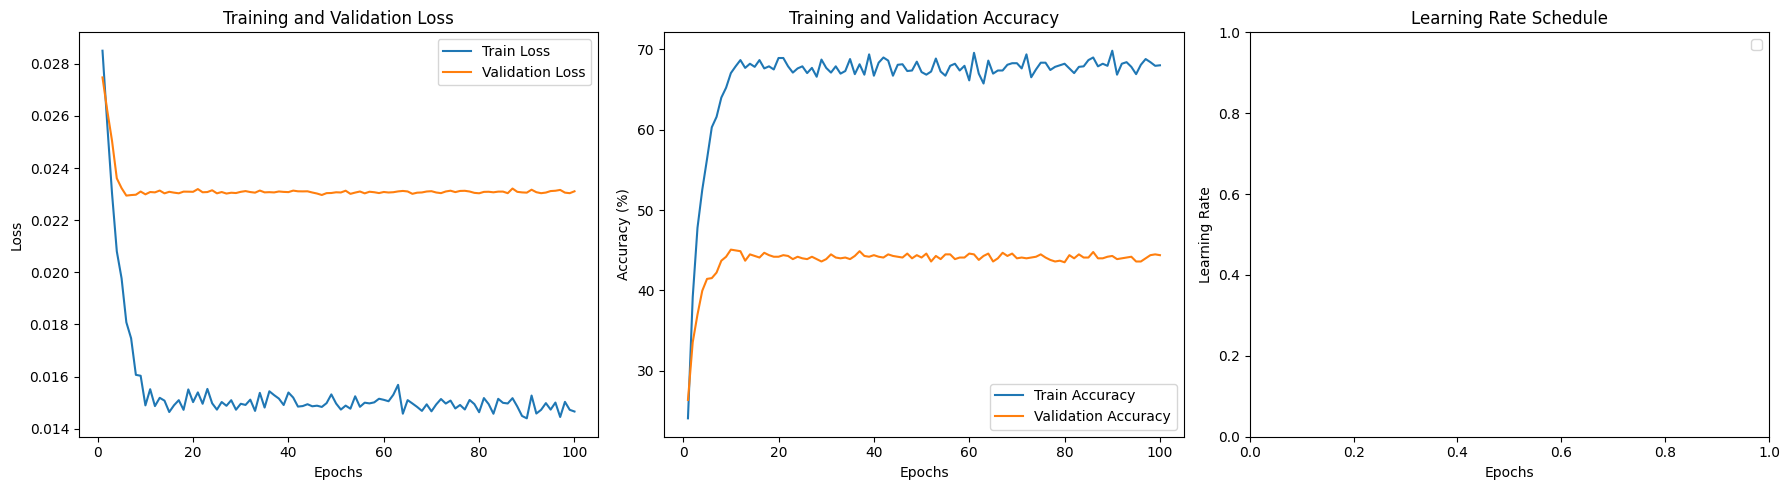

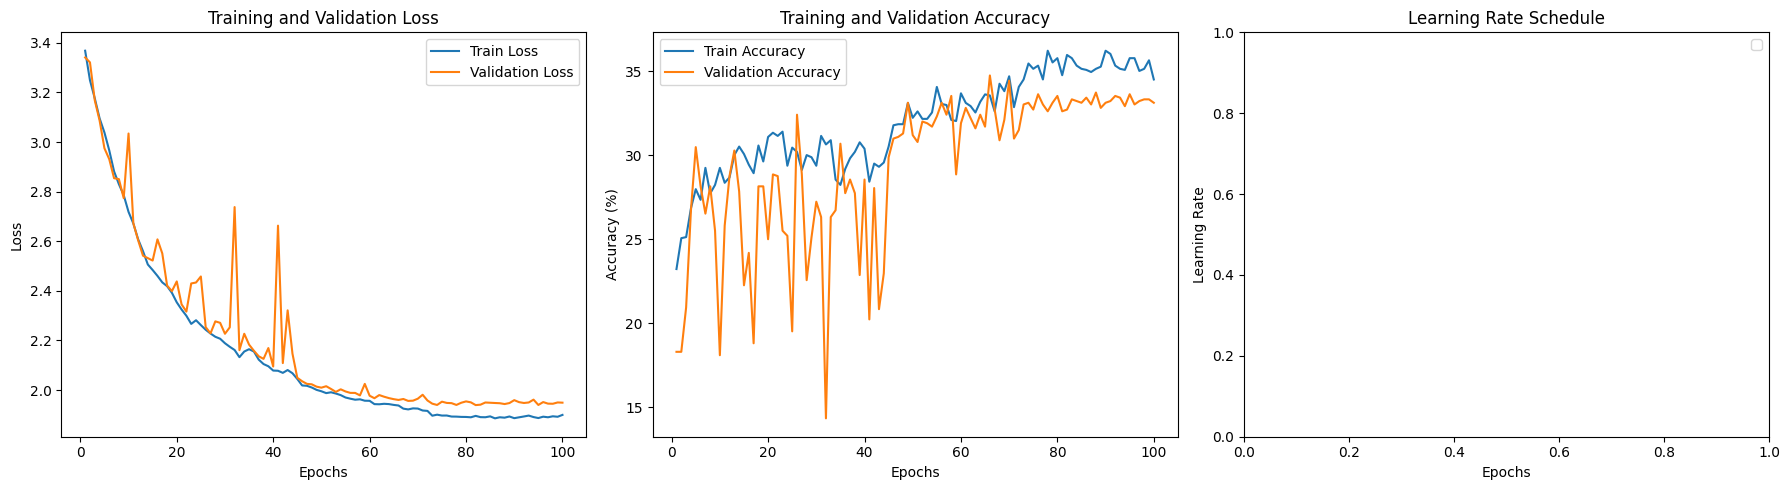

In [38]:
# Example usage for EEG model
if CFG.EEG:
    plot_training_results(
        num_epochs=CFG.EPOCHS,
        checkpoint_file=os.path.join(CFG.checkpoint_dir, "eeg_checkpoint.pth.tar")
    )

# Example usage for Spectrogram model
if CFG.SPEC:
    plot_training_results(
        num_epochs=CFG.EPOCHS,
        checkpoint_file=os.path.join(CFG.checkpoint_dir, "spec_checkpoint.pth.tar")
    )

# Example usage for Combined model
if not CFG.EEG and not CFG.SPEC:
    plot_training_results(
        num_epochs=CFG.EPOCHS,
        checkpoint_file=os.path.join(CFG.checkpoint_dir, "combined_checkpoint.pth.tar")
    )

Loading checkpoint '/home/data2/ronak/kou/checkpoints/eeg_checkpoint.pth.tar'
Loading checkpoint '/home/data2/ronak/kou/checkpoints/spec_checkpoint.pth.tar'
Loading checkpoint '/home/data2/ronak/kou/checkpoints/combined_checkpoint.pth.tar'


/tmp/ipykernel_2118465/1050492338.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2118465/1050492338.py:148: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2118465/1050492338.py:173: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


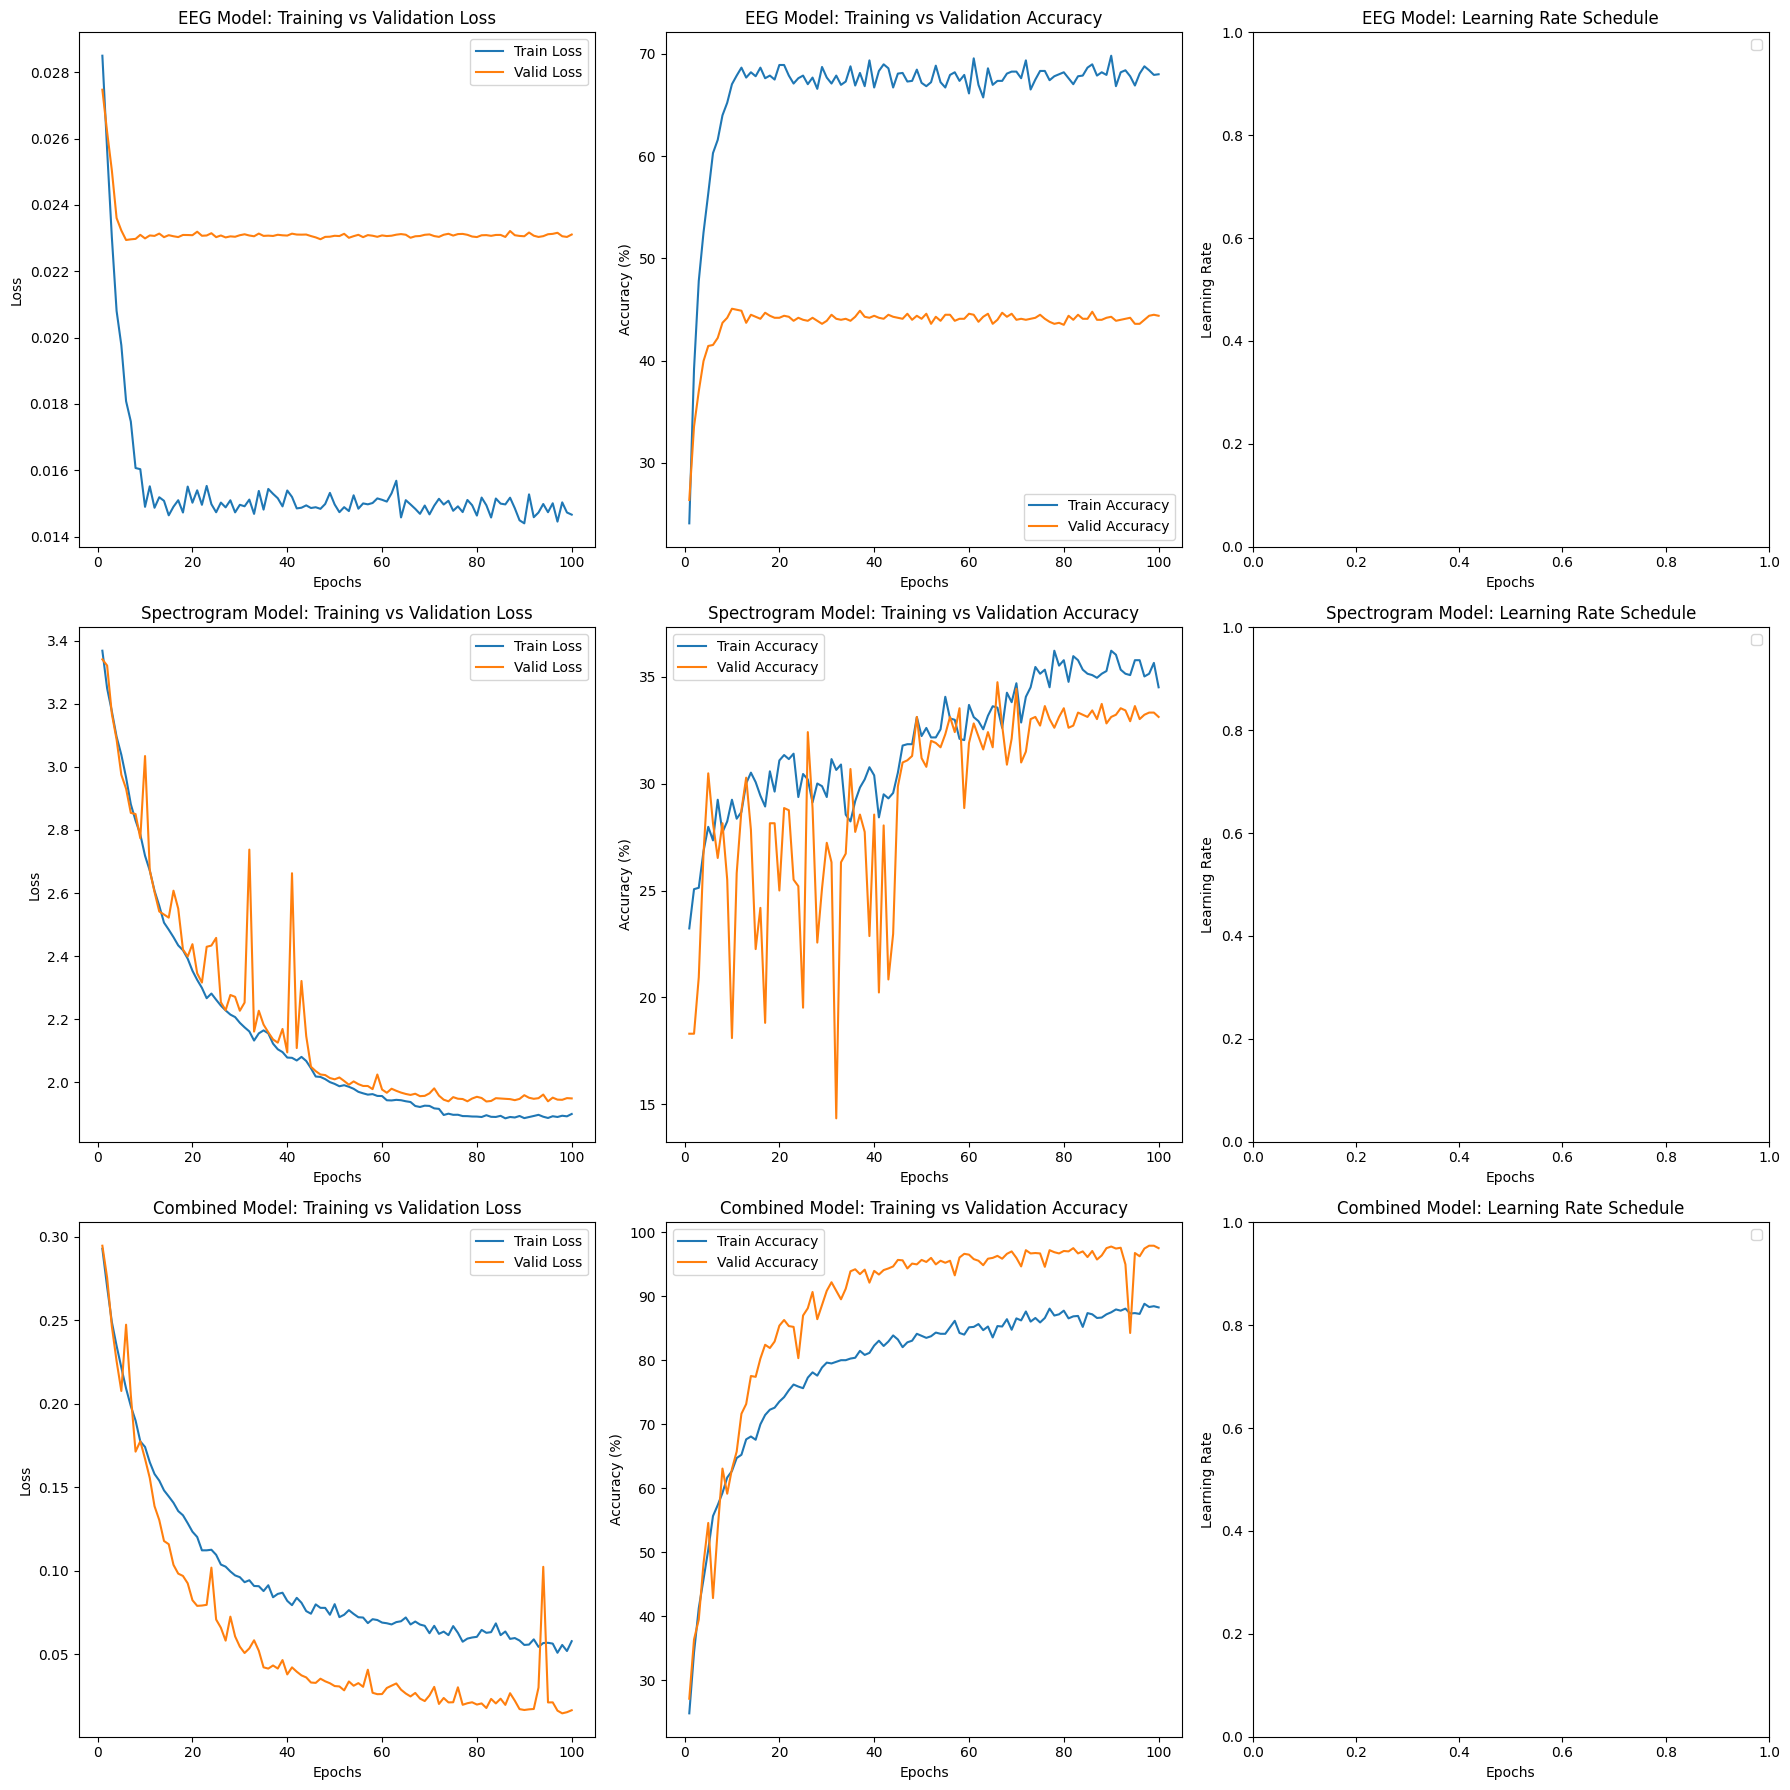

In [39]:
# Plotting individual metrics for all models
plot_individual_metrics(
    checkpoint_dir=CFG.checkpoint_dir,
    eeg_filename="eeg_checkpoint.pth.tar",
    spec_filename="spec_checkpoint.pth.tar",
    combined_filename="combined_checkpoint.pth.tar"
)

In [48]:
from PIL import Image
from captum.attr import IntegratedGradients, visualization
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [41]:
checkpoint_filename = "combined_checkpoint.pth.tar"


optimizer = torch.optim.AdamW(multimodal_model.parameters(), lr=0.001)
start_epoch, train_losses, valid_losses, train_accuracies, valid_accuracies, lr_scheduler = load_checkpoint(CFG.checkpoint_dir, checkpoint_filename, multimodal_model, optimizer)

Loading checkpoint '/home/data2/ronak/kou/checkpoints/combined_checkpoint.pth.tar'


In [42]:
import shap

In [43]:
# Initialize an empty list to store EEG data
background_data = []

# Define the number of samples you want to collect
num_samples = 100  # Adjust this number based on your dataset size and diversity

# Gather a smaller subset of EEG data for the background
background_samples = []
for i, ((eeg_data, _), _) in enumerate(train_loader):
    if i >= 10:  # Collect data from the first 10 batches
        break
    background_samples.append(eeg_data)

background_data = torch.cat(background_samples, dim=0)[:num_samples]

In [44]:
# Assuming you select an example from the train loader
for (eeg_data, _), _ in train_loader:
    eeg_data_sample = eeg_data[:1]  # Use just one sample for SHAP analysis
    break

In [45]:
# Move the background data and samples to analyze to the GPU
background_data = background_data.to(CFG.device)
eeg_data_sample = eeg_data_sample.to(CFG.device)

In [46]:
# Initialize the explainer with the model and a subset of the background data
explainer = shap.GradientExplainer(eeg_model, background_data)

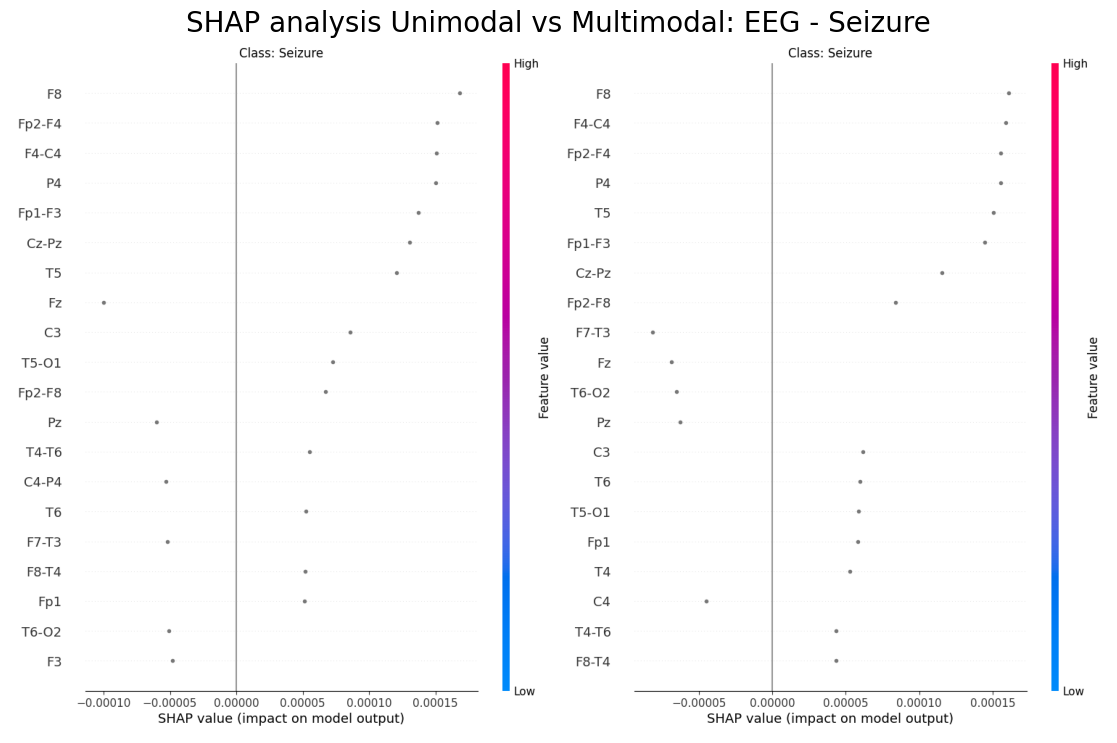

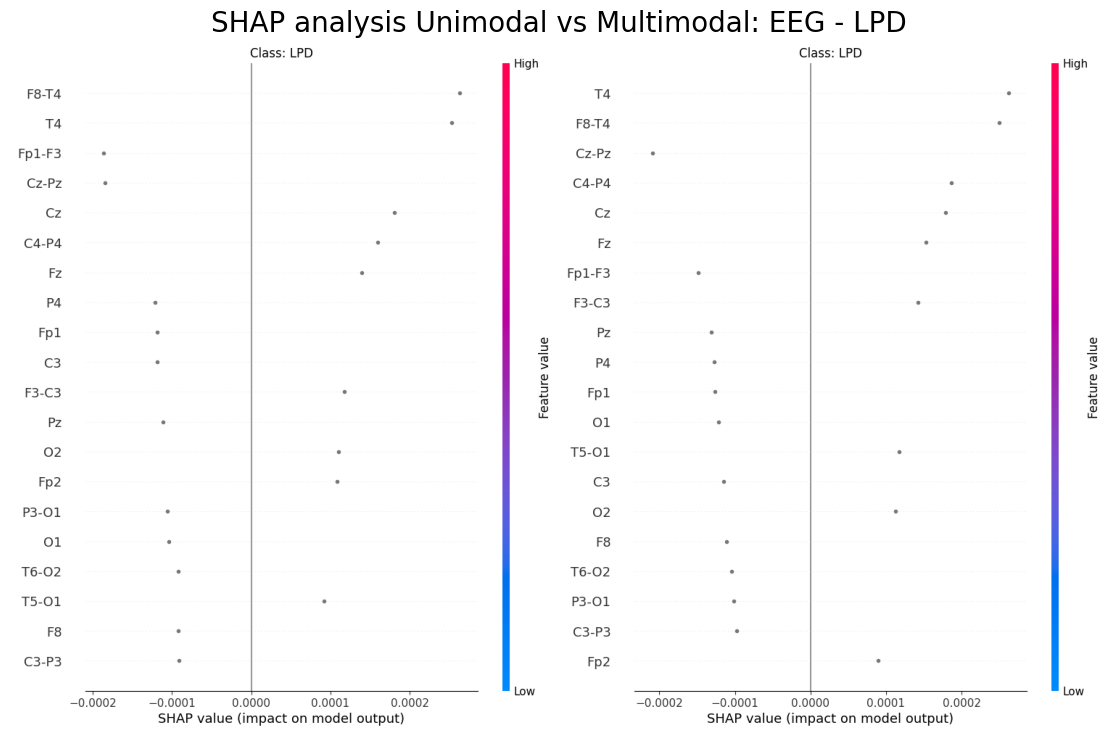

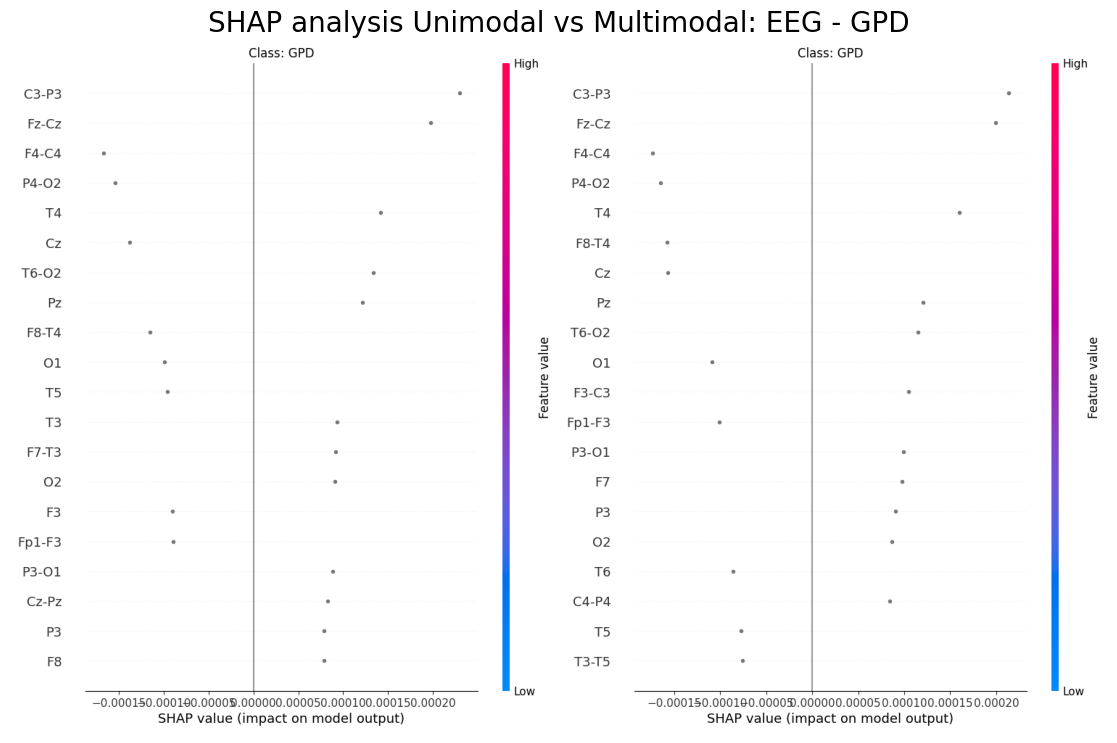

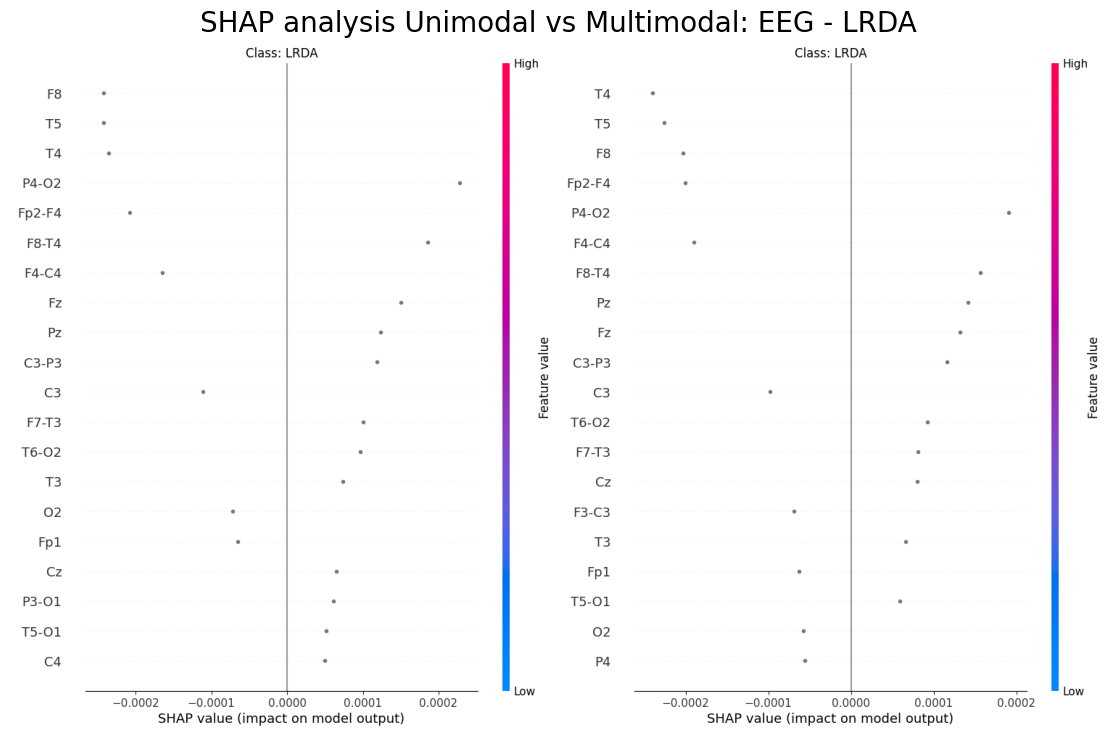

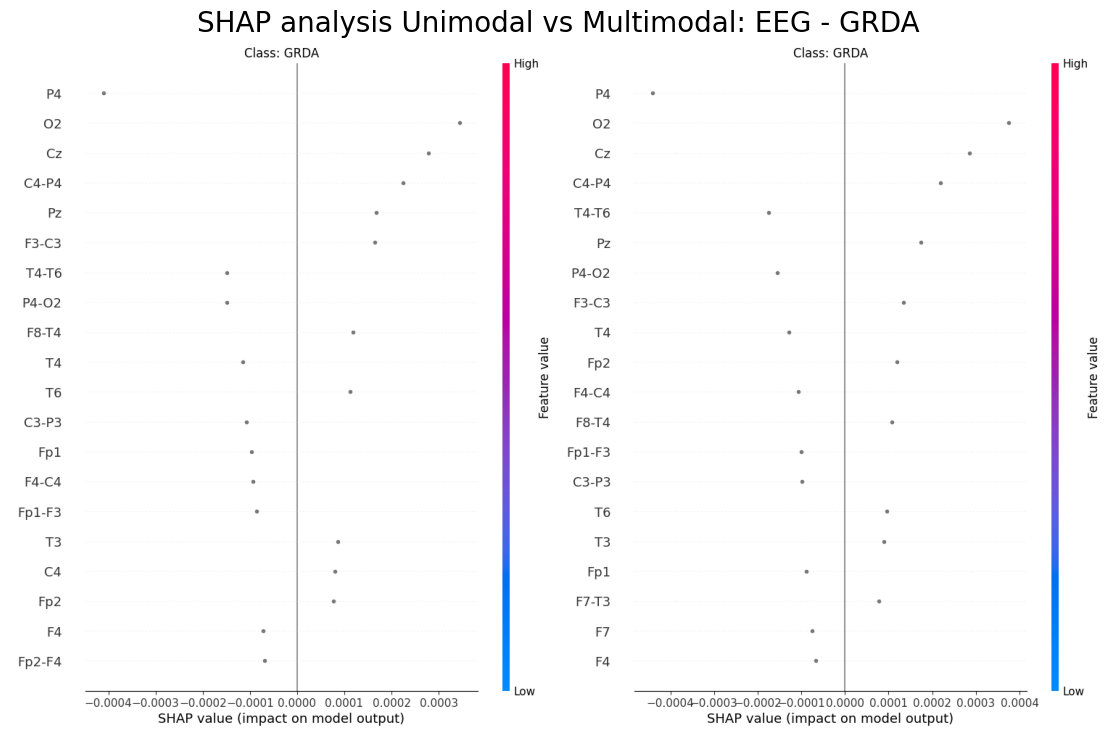

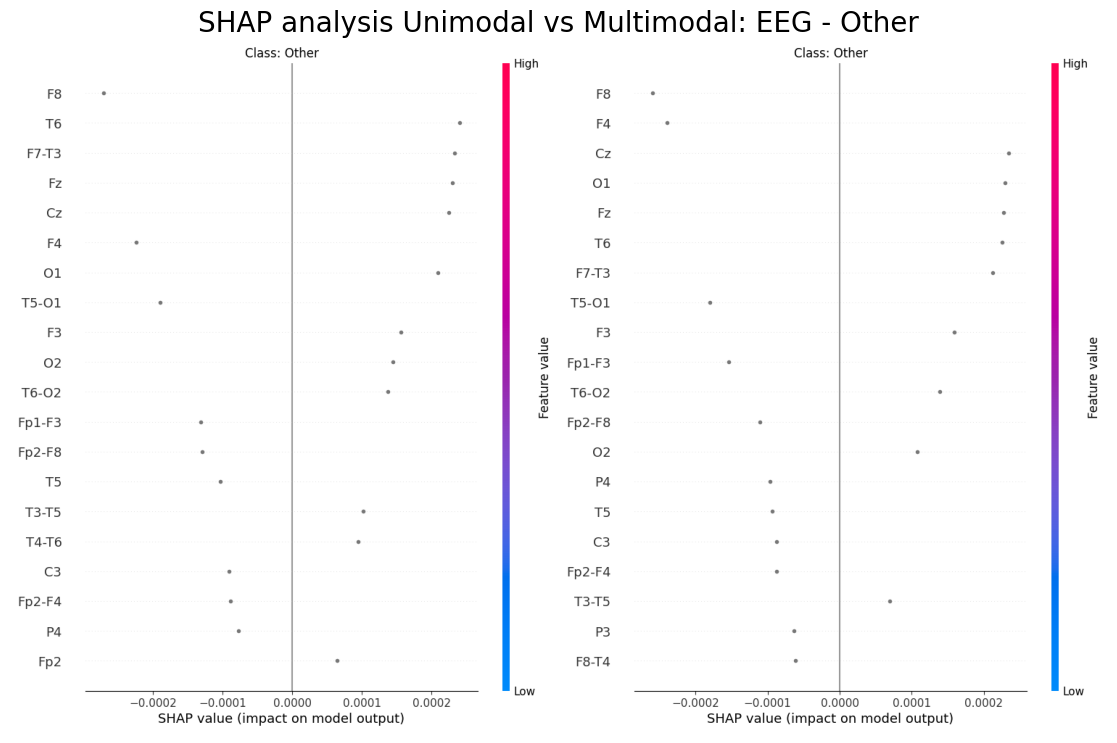

In [50]:
num_classes = CFG.n_classes
class_names = CFG.classes
# Load images for SHAP_ and SHAP_MULTIMODAL_
images_unimodal = [Image.open(f'image_outputs/SHAP_{i+1}.png') for i in range(num_classes)]
images_multimodal = [Image.open(f'image_outputs/SHAP_MULTIMODAL_{i+1}.png') for i in range(num_classes)]

# Combine each unimodal and multimodal pair side by side and save
for i in range(num_classes):
    width_unimodal, height_unimodal = images_unimodal[i].size
    width_multimodal, height_multimodal = images_multimodal[i].size

    combined_width = width_unimodal + width_multimodal
    combined_height = max(height_unimodal, height_multimodal)

    new_im = Image.new('RGB', (combined_width, combined_height))

    new_im.paste(images_unimodal[i], (0, 0))
    new_im.paste(images_multimodal[i], (width_unimodal, 0))

    # Display the combined image
    plt.figure(figsize=(combined_width // 100, combined_height // 100))  # Adjust figure size as necessary
    plt.imshow(new_im)
    plt.axis('off')  # Hide axes
    plt.title(f"SHAP analysis Unimodal vs Multimodal: EEG - {class_names[i]}", fontsize=20)
    plt.show()

In [51]:
def plot_spectrogram_only(processed, labels, num_labels=10, save_path='processed_spectrogram.png'):
    x_ticks = np.linspace(0, processed.shape[1] - 1, num_labels).astype(int)
    x_labels = [labels[i] for i in x_ticks]
    
    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed

    plt.title("Processed Spectrogram")
    if processed.ndim == 3 and processed.shape[2] > 1:
        plt.imshow(processed[:, :, 0], aspect='auto', cmap='viridis')
    else:
        plt.imshow(processed.squeeze(), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xticks(ticks=x_ticks, labels=x_labels, rotation=90)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.gcf().subplots_adjust(bottom=0.3)

    plt.tight_layout()
    plt.savefig(save_path)  # Save the plot to a file
    plt.show()

In [52]:
def plot_processed_eeg_data(processed_data, cfg, title_processed='Processed EEG Data', max_channels=37):
    """
    Plots processed EEG data including differential channels.

    Parameters:
    - processed_data: numpy array of shape (processed_channels, processed_samples) including differential channels
    - cfg: configuration object with channel names and mappings
    - title_processed: title for the processed data plot
    - max_channels: maximum number of channels to plot to avoid oversized images
    """
    processed_channels = cfg.in_channels  # Assuming this reflects the primary EEG channels without differentials
    differential_channels = len(cfg.map_features)  # Number of differential channels

    # Ensure the number of channels does not exceed max_channels
    total_channels = min(processed_channels + differential_channels, max_channels)
    fig, axes = plt.subplots(total_channels, 1, figsize=(15, 2 * total_channels), sharex='col')

    # Combine eeg_features and map_features for y-labels
    y_labels = cfg.eeg_features + [f'{a}-{b}' for a, b in cfg.map_features]

    # Plot the primary processed channels
    for i in range(min(processed_channels, total_channels)):
        axes[i].plot(processed_data[i], color='b')
        axes[i].set_ylabel(y_labels[i])
        if i == 0:
            axes[i].set_title(title_processed)

    # Plot differential signals below the primary channels
    differential_start = processed_channels  # Starting index for differential signals
    for j in range(min(differential_channels, total_channels - processed_channels)):
        k = differential_start + j
        if k < total_channels:
            axes[k].plot(processed_data[processed_channels + j], color='orange')
            axes[k].set_ylabel(y_labels[processed_channels + j])

    # Ensure labels and axes are correctly shown
    for ax in axes:
        ax.set_xlabel('Samples')
        if not ax.lines:
            ax.axis('off')  # Turn off empty plots

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [53]:
data, label = train_dataset[10]  # Replace 0 with the index you want to visualize

eeg_data, spectrogram_data = data

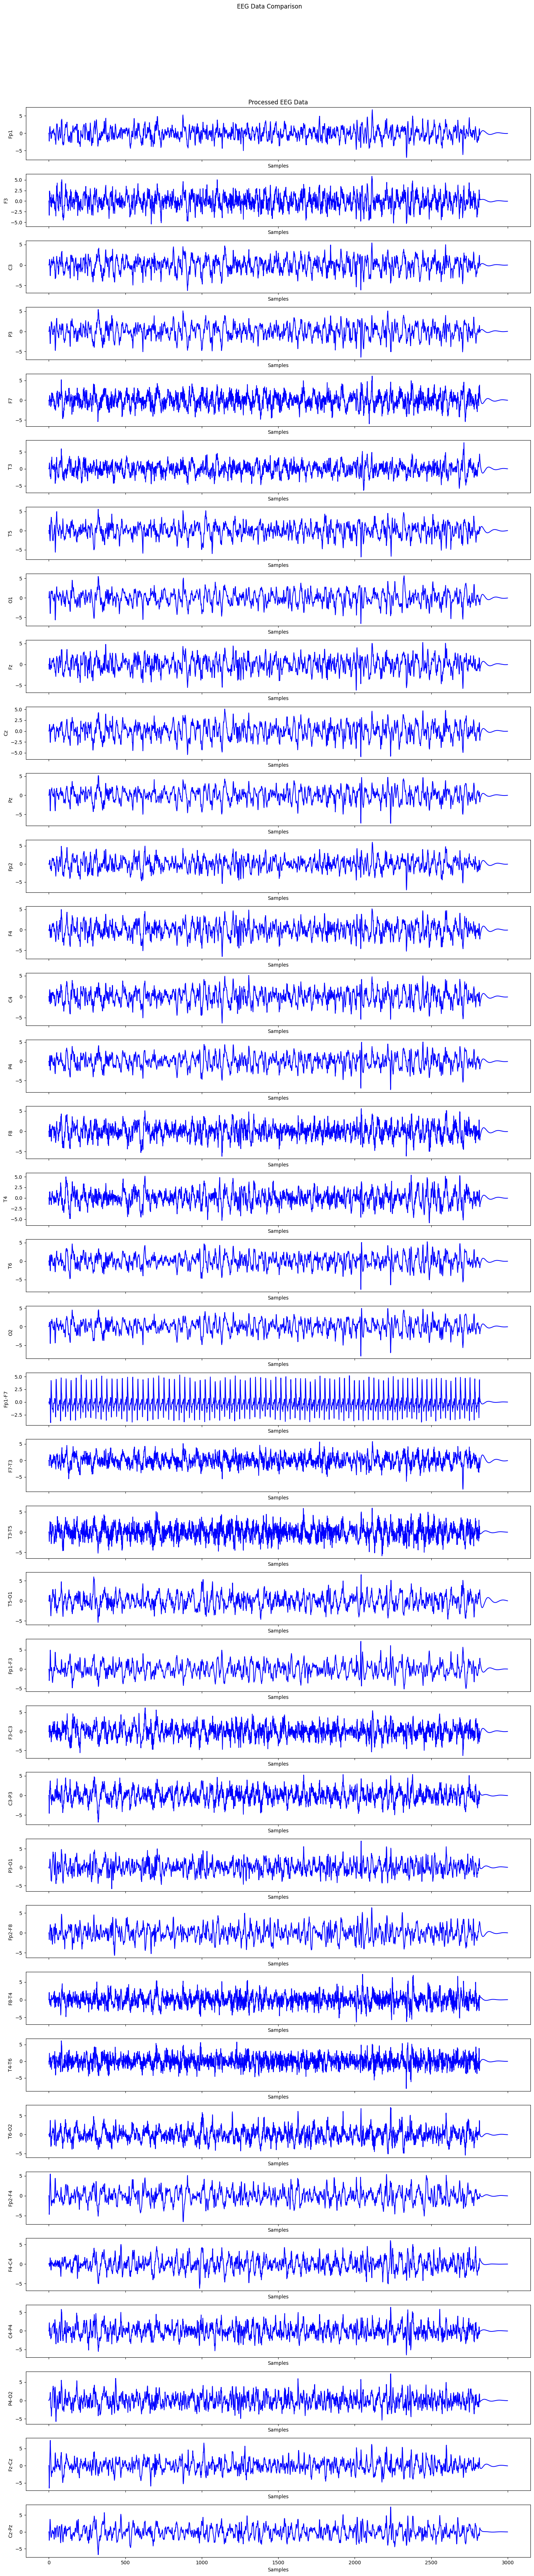

In [54]:
# Plot processed EEG Data
plot_processed_eeg_data(eeg_data.squeeze().cpu().numpy(), CFG, title_processed='Processed EEG Data')

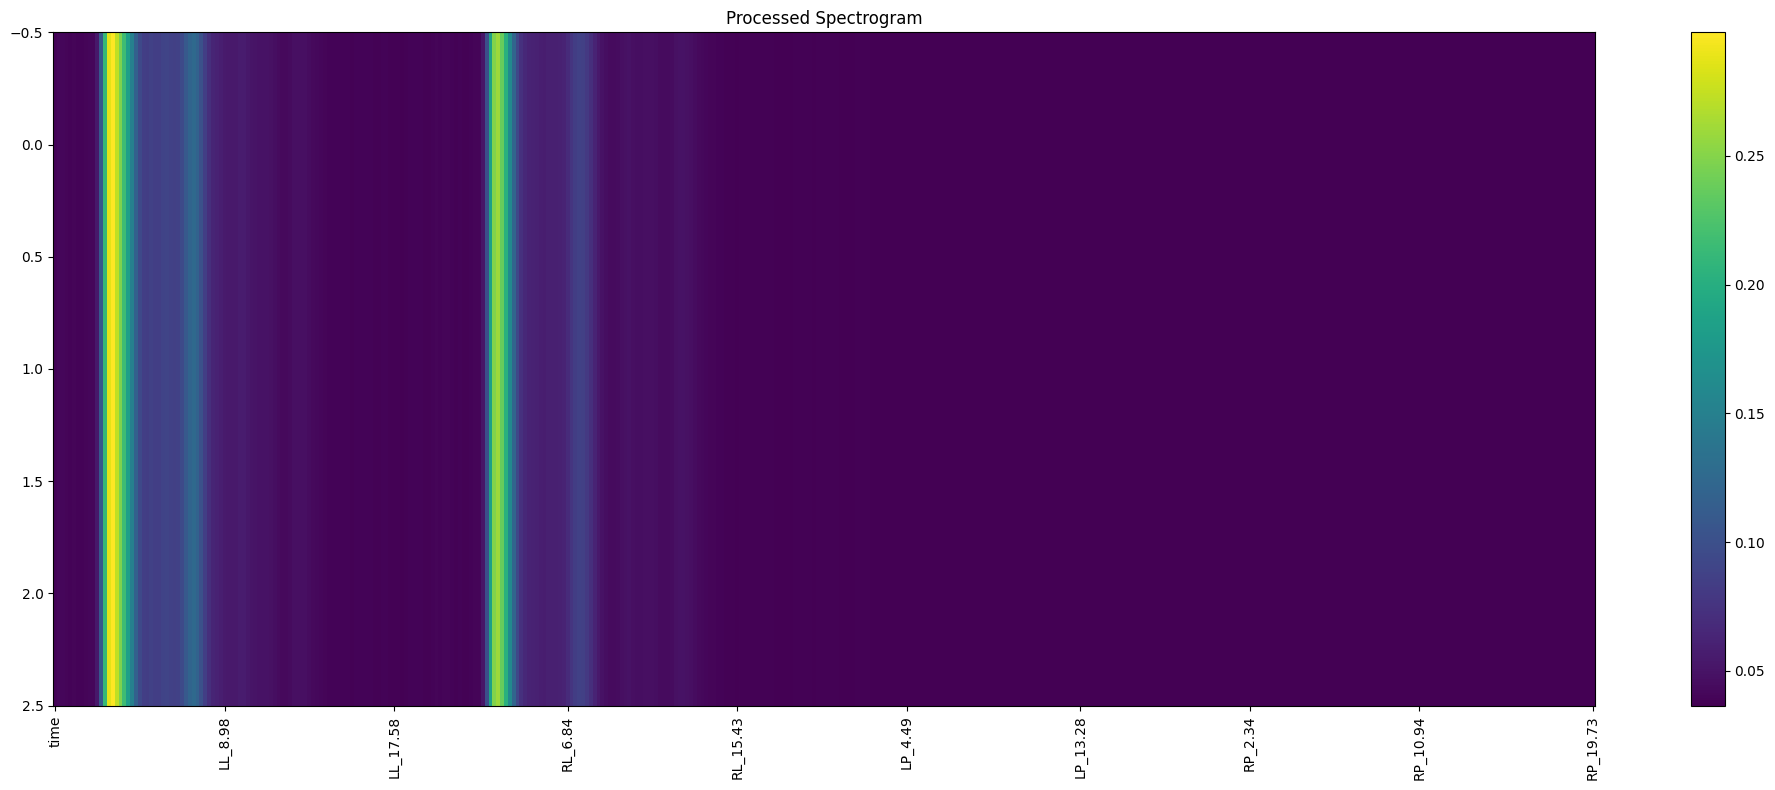

In [55]:
# Plot processed Spectrogram Data
plot_spectrogram_only(spectrogram_data, labels=CFG.SPECTR_COLUMNS, num_labels=10, save_path='raw_spectrogram_sample.png')

In [56]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torchvision.transforms as transforms
from torch.nn.functional import softmax
# Generate Segments
from skimage.segmentation import slic


In [57]:


# Load the spectrogram image
image_path = 'raw_spectrogram_sample.png'
image = Image.open(image_path).convert('RGB')
image = np.array(image)

In [58]:
# Define the prediction function for LIME
def predict_fn(images, model, device):
    images = [transforms.ToTensor()(Image.fromarray(img)).unsqueeze(0).to(device) for img in images]
    images = torch.cat(images, dim=0)
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        outputs = model(images)
    probs = softmax(outputs, dim=1).cpu().numpy()
    return probs

In [59]:
CFG.get_device()

CUDA is available. Using device: cuda (NVIDIA GeForce RTX 3090 Ti)


device(type='cuda')

In [60]:
# Initialize the LIME image explainer
explainer = lime_image.LimeImageExplainer()

In [61]:
# Visualize Segments
def plot_segments(image, segments):
    plt.figure(figsize=(10, 10))
    plt.imshow(mark_boundaries(image / 255.0, segments))
    plt.title("Segments")
    plt.axis('off')
    plt.show()

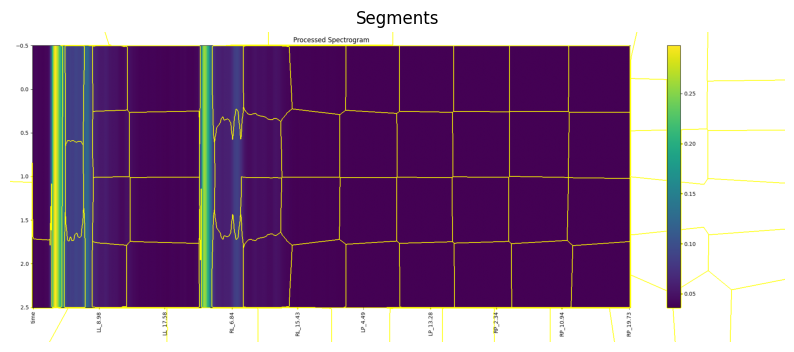

In [62]:
# Apply SLIC algorithm to segment the image
segments = slic(image, n_segments=100, compactness=10, sigma=1)

# Plot the segments to visualize them
plot_segments(image, segments)

In [63]:
# Explain the image using LIME
explanation = explainer.explain_instance(image, lambda x: predict_fn(x, spectrogram_model, CFG.device), top_labels=1, hide_color=0, num_samples=1000, segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10, sigma=1))

# Get the explanation for the top label
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

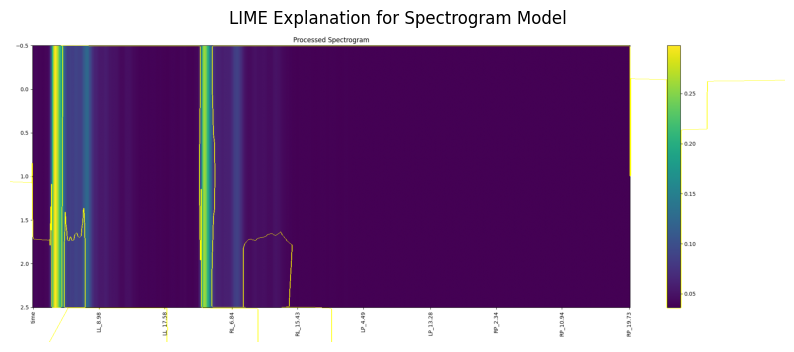

In [64]:
# Show the explanation
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title('LIME Explanation for Spectrogram Model')
plt.axis('off')
plt.show()

In [65]:
# Explain the image using LIME
multimodal_explanation = explainer.explain_instance(image, lambda x: predict_fn(x, multimodal_model.spectrogram_model, CFG.device), top_labels=1, hide_color=0, num_samples=1000, segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10, sigma=1))

# Get the explanation for the top label
multi_temp, multi_mask = multimodal_explanation.get_image_and_mask(multimodal_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

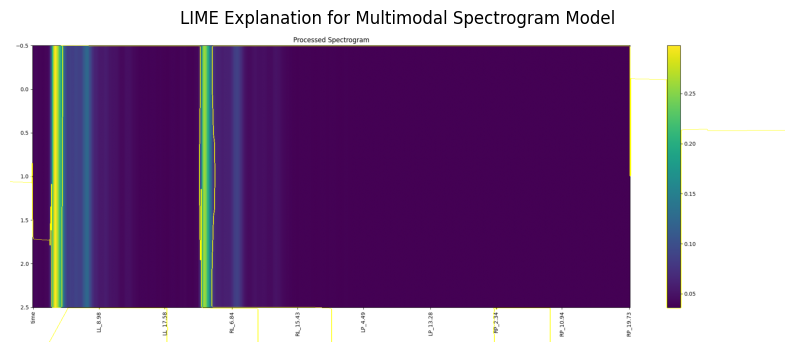

In [66]:
# Show the explanation
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(multi_temp / 255.0, multi_mask))
plt.title('LIME Explanation for Multimodal Spectrogram Model')
plt.axis('off')
plt.show()

In [94]:
def move_png_files(source_folder, destination_folder):
    """
    Collects all PNG files from the source folder and moves them to the destination folder.
    
    Parameters:
    - source_folder (str): Path to the source folder containing the PNG files.
    - destination_folder (str): Path to the destination folder where PNG files will be moved.
    """
    # Ensure destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get list of all files in source folder
    files = os.listdir(source_folder)

    # Loop through files and move PNG files to destination folder
    for file in files:
        if file.lower().endswith('.png'):
            src_path = os.path.join(source_folder, file)
            dst_path = os.path.join(destination_folder, file)
            shutil.move(src_path, dst_path)
            print(f"Moved: {file}")

# Usage example
source_folder = '/home/data2/ronak/kou'
destination_folder = '/home/data2/ronak/kou/image_outputs'
move_png_files(source_folder, destination_folder)

Moved: Spectrogram_saliency_map.png
Moved: EEG_Saliency_Map.png
Moved: LIME_Spectrogram_model.png
Moved: LIME_Spectrograms_segments.png


In [68]:
class CombinedDatasetSaliencyMap(Dataset):
    def __init__(self, metadata, cfg=CFG, training_flag=False, augmentations=None, plot=False):
        self.metadata = metadata
        self.cfg = cfg
        self.training_flag = training_flag
        self.augmentations = augmentations
        self.plot = plot

        # Set the random seed for reproducibility
        self.cfg.seed_everything(cfg)

        # Feature to index mapping from CFG
        self.feature_to_index = self.cfg.feature_to_index
        self.differential_channels_start_index = len(self.feature_to_index)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]

        # Process EEG data
        eeg_data = self.process_eeg(row)
        eeg_label = self.get_label(row)

        # Process Spectrogram data
        spectrogram_data = self.process_spectrogram(row)
        spectrogram_label = self.get_label(row)

        # Ensure the labels are the same
        assert torch.equal(eeg_label, spectrogram_label), "Labels do not match!"
        
        # Set requires_grad=True for saliency map computation
        eeg_data.requires_grad = True
        spectrogram_data.requires_grad = True

        return (eeg_data, spectrogram_data), eeg_label

    def process_eeg(self, row):
        eeg_id = row['eeg_id']
        eeg = load_train_eeg_frame(eeg_id)
        waves = eeg.values.T

        if self.cfg.AUGMENT:
            waves = self.mirror_eeg(waves)

        waves = self.butter_bandpass_filter(waves, self.cfg.bandpass_filter['low'], self.cfg.bandpass_filter['high'], self.cfg.sampling_rate)
        waves = self.handle_nan(waves)
        waves = self.calculate_differential_signals(waves)
        waves = self.denoise_filter(waves)
        waves = self.normalize(waves)
        waves = self.select_and_map_channels(waves, self.cfg.eeg_features, self.feature_to_index)
        waves = self.pad_or_truncate(waves, self.cfg.fixed_length)
        waves = waves[np.newaxis, ...]  # Add channel dimension for EEG data
        return torch.tensor(waves, dtype=torch.float32)

    def process_spectrogram(self, row):
        spec_id = row['spectrogram_id']
        raw_spectrogram = load_train_spectr_frame(spec_id)

        if isinstance(raw_spectrogram, pd.DataFrame):
            raw_spectrogram = raw_spectrogram.to_numpy()

        offset = row.get("spectrogram_label_offset_seconds", None)
        if offset is not None:
            offset = offset // 2
            basic_spectrogram = raw_spectrogram[:, offset:offset + 300]
            pad_size = max(0, 300 - basic_spectrogram.shape[1])
            basic_spectrogram = np.pad(basic_spectrogram, ((0, 0), (0, pad_size)), mode='constant')
        else:
            basic_spectrogram = raw_spectrogram

        spectrogram = basic_spectrogram.T
        spectrogram = self.pad_or_truncate(spectrogram, self.cfg.image_size)
        spectrogram = self.handle_nan(spectrogram)
        spectrogram = self.baseline_correction(spectrogram)
        spectrogram = self.apply_notch_filter(spectrogram)
        spectrogram = self.smooth_spectrogram(spectrogram)
        spectrogram = self.normalize_signal(spectrogram)
        spectrogram = self.resample_spectrogram(spectrogram, self.cfg.image_size)
        spectrogram = np.tile(spectrogram[..., None], (1, 1, 3))

        if self.plot:
            self.plot_spectrograms(basic_spectrogram, spectrogram, self.metadata.index.tolist(), num_labels=10)

        if self.augmentations:
            spectrogram = (spectrogram * 255).astype(np.uint8)
            augmented = self.augmentations(image=spectrogram)
            spectrogram = augmented['image']
            spectrogram = spectrogram.float() / 255.0
        else:
            spectrogram = spectrogram.astype(np.float32)
            spectrogram = torch.tensor(spectrogram).permute(2, 0, 1).float()

        return spectrogram

    def get_label(self, row):
        label_name = row['expert_consensus']
        label_idx = self.cfg.name2label[label_name]
        label = labels_to_probabilities(label_idx, self.cfg.n_classes)
        return label.clone().detach().float()

    def handle_nan(self, data):
        """Handle NaN values by replacing them with the mean of the respective channels."""
        data = data[~np.isnan(data).all(axis=1)]
        if data.size == 0:
            data = np.zeros((self.cfg.in_channels + len(self.cfg.map_features), self.cfg.fixed_length))
        else:
            where_nan = np.isnan(data)
            mean_values = np.nanmean(data, axis=1, keepdims=True)
            mean_values[np.isnan(mean_values)] = 0
            data[where_nan] = np.take(mean_values, np.where(where_nan)[0])
        return data

    def pad_or_truncate(self, data, length):
        if isinstance(length, int):
            if data.shape[1] < length:
                padding = np.zeros((data.shape[0], length - data.shape[1]))
                data = np.hstack((data, padding))
            else:
                data = data[:, :length]
        elif isinstance(length, tuple):
            target_rows, target_cols = length
            if data.shape[0] < target_rows:
                row_padding = np.zeros((target_rows - data.shape[0], data.shape[1]))
                data = np.vstack((data, row_padding))
            else:
                data = data[:target_rows, :]
            if data.shape[1] < target_cols:
                col_padding = np.zeros((data.shape[0], target_cols - data.shape[1]))
                data = np.hstack((data, col_padding))
            else:
                data = data[:, :target_cols]
        return data

    def butter_bandpass(self, lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        return butter(order, [low, high], btype='band')

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=5):
        b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
        return lfilter(b, a, data, axis=1)

    def calculate_differential_signals(self, data):
        num_pairs = len(self.cfg.map_features)
        differential_data = np.zeros((num_pairs, data.shape[1]))
        for i, (feat_a, feat_b) in enumerate(self.cfg.map_features):
            if feat_a in self.feature_to_index and feat_b in self.feature_to_index:
                differential_data[i, :] = data[self.feature_to_index[feat_a], :] - data[self.feature_to_index[feat_b], :]
            else:
                print(f"Feature {feat_a} or {feat_b} not found in feature_to_index")
        return np.vstack((data, differential_data))

    def denoise_filter(self, x):
        y = self.butter_bandpass_filter(x, self.cfg.bandpass_filter['low'], self.cfg.bandpass_filter['high'], self.cfg.sampling_rate, order=6)
        y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
        y = y[:, 0:-1:4]
        return y

    def normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        return (data - mean) / (std + 1e-6)

    def select_and_map_channels(self, data, channels, feature_to_index):
        selected_indices = [feature_to_index[ch] for ch in channels if ch in feature_to_index]
        differential_indices = list(range(self.differential_channels_start_index, self.differential_channels_start_index + len(self.cfg.map_features)))
        selected_data = data[selected_indices + differential_indices, :]
        return selected_data

    def mirror_eeg(self, data):
        indx1 = [self.cfg.feature_to_index[x] for x in self.cfg.LL + self.cfg.LP if x in self.cfg.feature_to_index]
        indx2 = [self.cfg.feature_to_index[x] for x in self.cfg.RL + self.cfg.RP if x in self.cfg.feature_to_index]
        data[indx1, :], data[indx2, :] = data[indx2, :], data[indx1, :]
        return data

    def baseline_correction(self, sig):
        sig -= np.mean(sig, axis=0)
        return sig

    def normalize_signal(self, sig):
        sig = np.nan_to_num(sig, nan=np.nanmean(sig))
        return (sig - np.min(sig)) / (np.max(sig) - np.min(sig) + 1e-6)
    
    def apply_notch_filter(self, sig, freq=60, fs=200, quality=30):
        b, a = iirnotch(freq, quality, fs)
        sig = filtfilt(b, a, sig, axis=0)
        return sig
    
    def smooth_spectrogram(self, sig, sigma=1.0):
        sig = gaussian_filter(sig, sigma=sigma)
        return sig

    def resample_spectrogram(self, sig, target_shape):
        sig = resize(sig, target_shape, mode='reflect', anti_aliasing=True)
        return sig

In [85]:
# Assuming 'metadata' is a pandas DataFrame containing your dataset information
single_metadata = metadata.iloc[[10]]  # Select a single row
single_dataset = CombinedDatasetSaliencyMap(single_metadata, cfg=CFG, training_flag=False, augmentations=None, plot=False)
single_dataloader = DataLoader(single_dataset, batch_size=1, shuffle=False)

In [ ]:
single_dataset

In [86]:
multimodal_model.eval()

MultimodalModel(
  (eeg_model): EEGNet(
    (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
    (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwiseConv): Conv2d(8, 16, kernel_size=(37, 1), stride=(1, 1), groups=8, bias=False)
    (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ELU(alpha=1.0)
    (avg_pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (separableConv): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, bias=False)
    (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avg_pool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=1488, out_features=6, bias=True)
    (log_softmax): LogSoftmax(dim=1)
  )
  (spectro

In [100]:
# Function to plot EEG saliency map
def plot_eeg_saliency(saliency, cfg,max_channels=37):
    processed_channels = cfg.in_channels  # Assuming this reflects the primary EEG channels without differentials
    differential_channels = len(cfg.map_features)  # Number of differential channels

    # Ensure the number of channels does not exceed max_channels
    total_channels = min(processed_channels + differential_channels, max_channels)
    

    # Combine eeg_features and map_features for y-labels
    y_labels = cfg.eeg_features + [f'{a}-{b}' for a, b in cfg.map_features]
    num_channels, num_samples = saliency.shape
    fig, axes = plt.subplots(total_channels, 1, figsize=(15, 2 * total_channels), sharex=True)

    for i in range(num_channels):
        axes[i].plot(saliency[i], color='r')
        axes[i].set_ylabel(y_labels[i])

    plt.xlabel('Samples')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [101]:
# Function to plot Spectrogram saliency map
def plot_spectrogram_saliency(saliency, labels, num_labels=10):
    x_ticks = np.linspace(0, saliency.shape[1] - 1, num_labels).astype(int)
    x_labels = [labels[i] for i in x_ticks]

    plt.figure(figsize=(20, 8))
    plt.title("Spectrogram Saliency Map")
    plt.imshow(saliency, aspect='auto', cmap='hot')
    plt.colorbar()
    plt.xticks(ticks=x_ticks, labels=x_labels, rotation=90)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.gcf().subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

In [102]:
def generate_saliency_maps(model, dataloader):
    model.eval()
    for (eeg_data, spectrogram_data), label in dataloader:
        eeg_data = eeg_data.to(CFG.device)
        spectrogram_data = spectrogram_data.to(CFG.device)
        label = label.to(CFG.device)

        # Forward pass
        output = model(eeg_data, spectrogram_data)
        output_idx = output.argmax(dim=1)
        output_max = output[0, output_idx]

        # Retain gradients for non-leaf tensors
        eeg_data.retain_grad()
        spectrogram_data.retain_grad()

        # Zero gradients
        model.zero_grad()

        # Backward pass for EEG saliency
        output_max.backward(retain_graph=True)
        eeg_saliency = eeg_data.grad.data.abs().squeeze().cpu().numpy()

        # Zero gradients
        model.zero_grad()

        # Backward pass for Spectrogram saliency
        output_max.backward()
        spectrogram_saliency = spectrogram_data.grad.data.abs().max(dim=1, keepdim=True)[0].squeeze().cpu().numpy()

        # Plot the saliency maps
        plot_eeg_saliency(eeg_saliency, CFG)
        plot_spectrogram_saliency(spectrogram_saliency, CFG.SPECTR_COLUMNS)

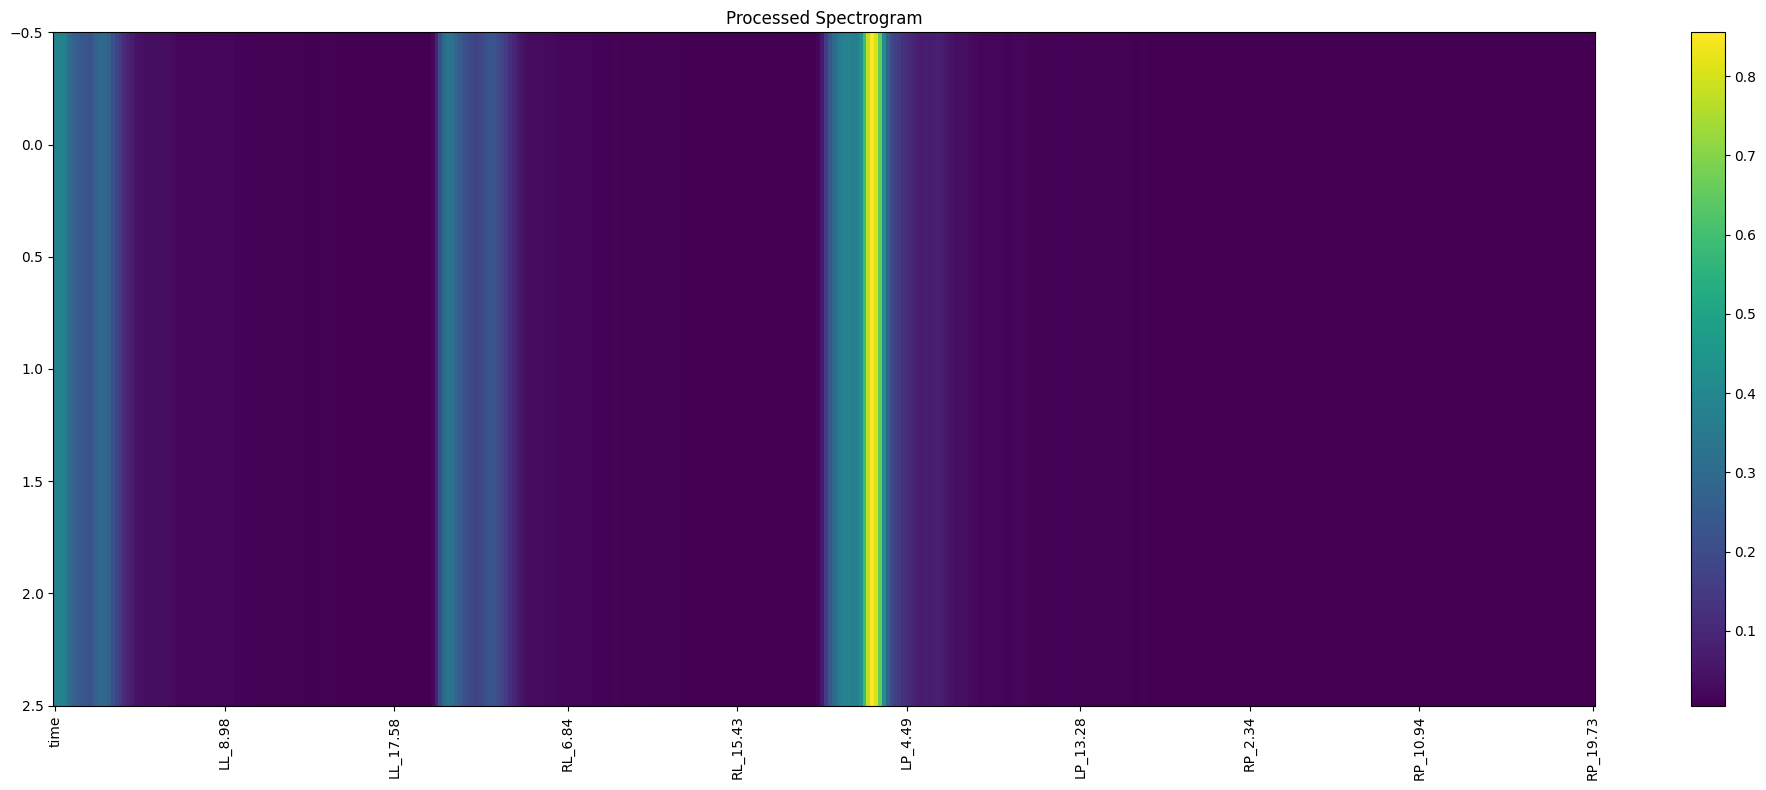

In [103]:
data, label = single_dataset[0]  # Replace 0 with the index you want to visualize

eeg_data, spectrogram_data = data
spectrogram_data = spectrogram_data.detach().numpy()



plot_spectrogram_only(spectrogram_data, labels=CFG.SPECTR_COLUMNS, num_labels=10, save_path='raw_spectrogram_sample.png')

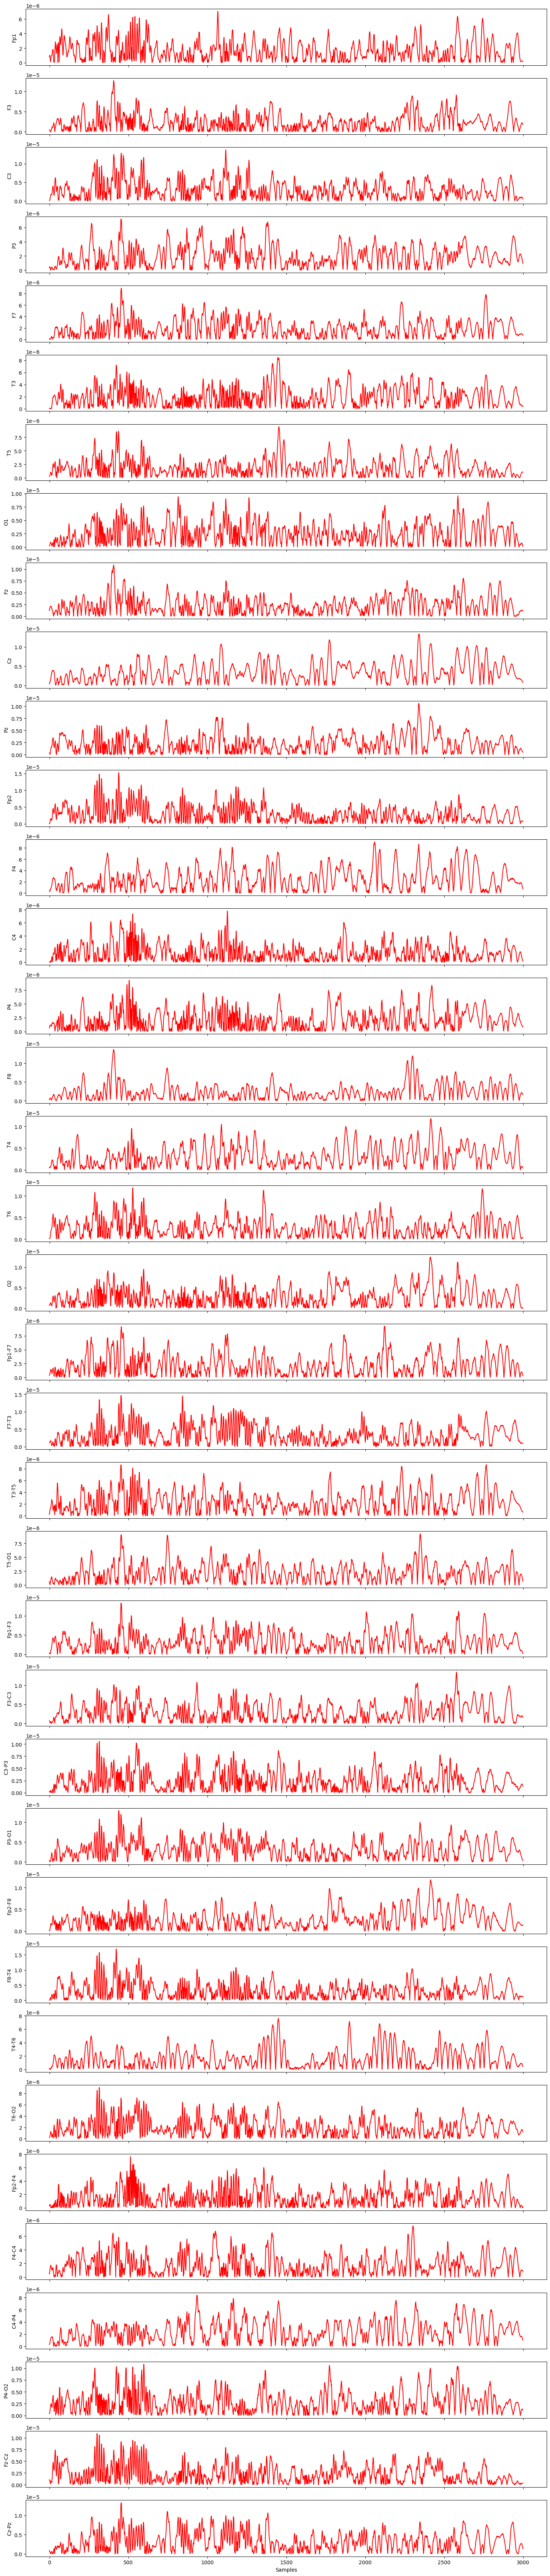

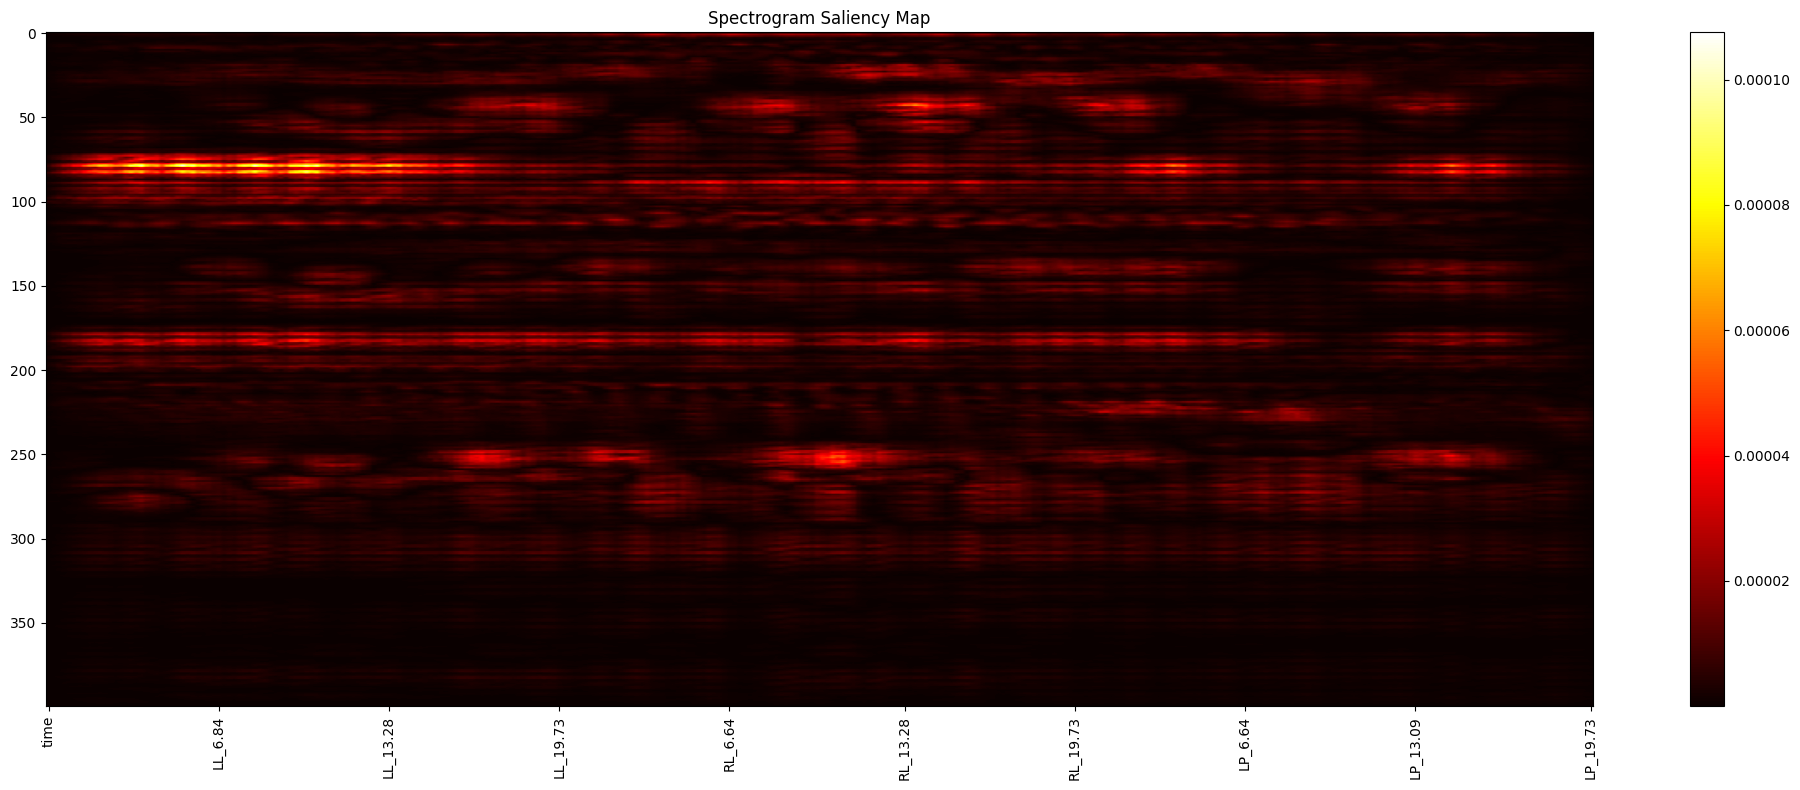

In [104]:
# Generate saliency maps
generate_saliency_maps(multimodal_model, single_dataloader)